<a href="https://colab.research.google.com/github/davibuss/Homework2-Caltech101/blob/master/Homework2_MLDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Install requirements**

In [ ]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'
!pip install imutils

  Using cached https://files.pythonhosted.org/packages/88/95/90e8c4c31cfc67248bf944ba42029295b77159982f532c5689bcfe4e9108/torch-1.3.1-cp36-cp36m-manylinux1_x86_64.whl
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 1.3.1 which is incompatible.
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0


  Using cached https://files.pythonhosted.org/packages/24/19/4804aea17cd136f1705a5e98a00618cb8f6ccc375ad8bfa437408e09d058/torch-1.4.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1


In [ ]:
!pip install pretrainedmodels

     |████████████████████████████████| 61kB 2.1MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=263dd3833167520bed415b4065b4287924f7bd46ec27ba5fd4e3464f86d3f0c2
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


# PRELIMINARY ELEMENTS

In [ ]:
import os
import logging
import os.path
import sys
import re
import cv2
import numpy as np
import time

from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader,Dataset
from torch.backends import cudnn
from torchvision.datasets import VisionDataset
from torch.utils.data.sampler import SubsetRandomSampler
import pretrainedmodels
from torchvision.utils import make_grid
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm.notebook import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# TRAINING FROM SCRATCH

**Set Arguments**

## Learning rate optimization

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 20    # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10     # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [ ]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

**Prepare Dataset**

In [ ]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/davibuss/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'
from Caltech101.caltech_dataset import Caltech


# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)
print(type(train_dataset))
 # split to train val

train_len = int(train_dataset.__len__() * 0.5)
val_len = int(train_dataset.__len__() * 0.5)
train_indexes = np.arange(train_dataset.__len__())
print(train_indexes)
train_labels = np.empty(train_dataset.__len__(), dtype=int)


for index in train_indexes:
  train_labels[index] = train_dataset.__getitem__(index)[1]

print(train_labels)  


train_indexes, val_indexes, _, _ = train_test_split(train_indexes, train_labels, test_size=0.5, random_state=42, stratify=train_labels)


"""
validation_split = 0.5
dataset_size = len(train_dataset)
#print(dataset_size)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if 1 :
    np.random.seed(1337)
    np.random.shuffle(indices)
train_indexes, val_indexes = indices[split:], indices[:split]

print(type(train_indexes))
#train_indexes = SubsetRandomSampler(train_indices)
#val_indexes = SubsetRandomSampler(valid_indices)
#train_indexes, val_indexes = 
#print(type(train_indexes))
#print(train_indexes)
"""

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))


<class 'Caltech101.caltech_dataset.Caltech'>
[   0    1    2 ... 5781 5782 5783]
[  0   0   0 ... 100 100 100]
Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


In [ ]:
train_classes = np.zeros(101)

for elem in train_dataset:
  train_classes[elem[1]] += 1

val_classes = np.zeros(101)

for elem in val_dataset:
  val_classes[elem[1]] += 1

[ 18. 267.  14.  14.  15.  18.  15.  11.  42.  33.  15.  28.  30.  17.
  14.  41.  16.  20.  20.  36.  16.  23.  25.  23.  17.  17.  19.  22.
  17.  21.  23.  25.  21.  18.  21.  29. 145. 145.  23.  22.  15.  11.
  12.  17.  33.  33.  14.  18.  30.  27.  10.  22.  28.  38.  20.  27.
  66.  26.  13.  22.  15.  14.  29.  11.  26. 266.  18.  12.  13.  15.
  13.  15.  18.  11.  19.  27.  19.  17.  14.  21.  13.  28.  19.  11.
  21.  15.  28.  20.  21.  12.  29.  16.  28.  25.  80.  12.  20.  12.
  18.  13.  20.]


[]

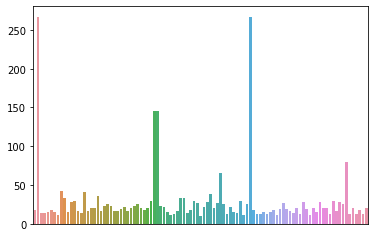

In [ ]:
print(train_classes)
ax=sns.barplot(x=np.linspace(0, 100, num=101),y=train_classes)
ax.set_xticks([])

**Prepare Dataloaders**

In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)



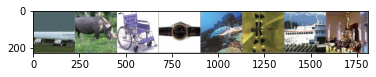

In [ ]:

def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    img = std*img + mean
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.pause(0.001) 
  
images, labels = next(iter(train_dataloader))
grid_img = make_grid(images[:8], nrow=8)
imshow(grid_img)

**Prepare Network**

In [ ]:
net = alexnet() # Loading AlexNet model

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(DEVICE)

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

cuda:0


**Prepare Training**

In [ ]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY,nesterov=True)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [ ]:
def validate(net):
  print('Validating')
  net=net.to(DEVICE)
  net.eval()
  running_corrects = 0
  with torch.no_grad():
    for images, labels in tqdm(val_dataloader):
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      
      outputs = net(images)

      
      _, preds = torch.max(outputs.data, 1)

      
      running_corrects += torch.sum(preds == labels.data).data.item()

      
      loss = criterion(outputs, labels)

   
  accuracy = 100.*running_corrects / float(len(val_dataset))

  print('Validation Accuracy: {}'.format(accuracy))
  print()
  return loss,accuracy

In [ ]:
def fit(net):
  net=net.to(DEVICE)
  cudnn.benchmark
  current_step = 0
  train_loss , train_accuracy = [], []
  val_loss , val_accuracy = [], []

  for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

    running_corrects = 0.0
    running_loss = 0.0

    for images, labels in train_dataloader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      
      net.train()

      optimizer.zero_grad()

      outputs = net(images)

      loss = criterion(outputs, labels)

      if current_step % LOG_FREQUENCY == 0:
        print('Step {}, Loss {}'.format(current_step, loss.item()))

      loss.backward()
      optimizer.step()

      _, preds = torch.max(outputs.data, 1)

      running_corrects += torch.sum(preds == labels.data).data.item()
      running_loss += loss.item() * images.size(0)
      

      current_step += 1

    #train_loss.append(running_loss / float(len(train_dataset)))
    train_loss.append(running_loss / float(len(train_dataloader)*BATCH_SIZE))
    #train_accuracy.append(100.*running_corrects / float(len(train_dataset)))
    train_accuracy.append(100.*running_corrects / float(len(train_dataloader)*BATCH_SIZE))

    validate_returns = validate(net)

    val_accuracy.append(validate_returns[1])
    val_loss.append(validate_returns[0])

    scheduler.step() 

  return  train_loss, val_loss, train_accuracy, val_accuracy


In [ ]:
start = time.time()
train_loss, val_loss, train_accuracy, val_accuracy = fit(net)

end = time.time()

print((end-start)/60, 'minutes')

Starting epoch 1/20, LR = [0.01]
Step 0, Loss 4.616341590881348
Step 10, Loss 4.602687358856201
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 2/20, LR = [0.01]
Step 20, Loss 4.581329822540283
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 3/20, LR = [0.01]
Step 30, Loss 4.559183597564697
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 4/20, LR = [0.01]
Step 40, Loss 4.487996578216553
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 5/20, LR = [0.01]
Step 50, Loss 4.214214324951172
Validating



Validation Accuracy: 11.410788381742739

Starting epoch 6/20, LR = [0.01]
Step 60, Loss 4.165308952331543
Validating



Validation Accuracy: 9.232365145228215

Starting epoch 7/20, LR = [0.01]
Step 70, Loss 4.375718116760254
Validating



Validation Accuracy: 11.203319502074688

Starting epoch 8/20, LR = [0.01]
Step 80, Loss 4.0786027908325195
Validating



Validation Accuracy: 12.344398340248963

Starting epoch 9/20, LR = [0.01]
Step 90, Loss 3.973114013671875
Validating



Validation Accuracy: 15.318118948824344

Starting epoch 10/20, LR = [0.01]
Step 100, Loss 4.151137351989746
Validating



Validation Accuracy: 16.424619640387274

Starting epoch 11/20, LR = [0.001]
Step 110, Loss 3.8767077922821045
Step 120, Loss 4.181012153625488
Validating



Validation Accuracy: 16.528354080221302

Starting epoch 12/20, LR = [0.001]
Step 130, Loss 3.9788174629211426
Validating



Validation Accuracy: 17.15076071922545

Starting epoch 13/20, LR = [0.001]
Step 140, Loss 4.041245460510254
Validating



Validation Accuracy: 17.461964038727523

Starting epoch 14/20, LR = [0.001]
Step 150, Loss 3.841766595840454
Validating



Validation Accuracy: 18.672199170124482

Starting epoch 15/20, LR = [0.001]
Step 160, Loss 3.9782614707946777
Validating



Validation Accuracy: 19.08713692946058

Starting epoch 16/20, LR = [0.001]
Step 170, Loss 4.013372898101807
Validating



Validation Accuracy: 19.67496542185339

Starting epoch 17/20, LR = [0.001]
Step 180, Loss 3.971959114074707
Validating



Validation Accuracy: 20.228215767634854

Starting epoch 18/20, LR = [0.001]
Step 190, Loss 3.905245542526245
Validating



Validation Accuracy: 20.53941908713693

Starting epoch 19/20, LR = [0.001]
Step 200, Loss 3.9358129501342773
Validating



Validation Accuracy: 20.919778699861688

Starting epoch 20/20, LR = [0.001]
Step 210, Loss 3.8556900024414062
Validating



Validation Accuracy: 20.885200553250346

7.513168223698934 minutes


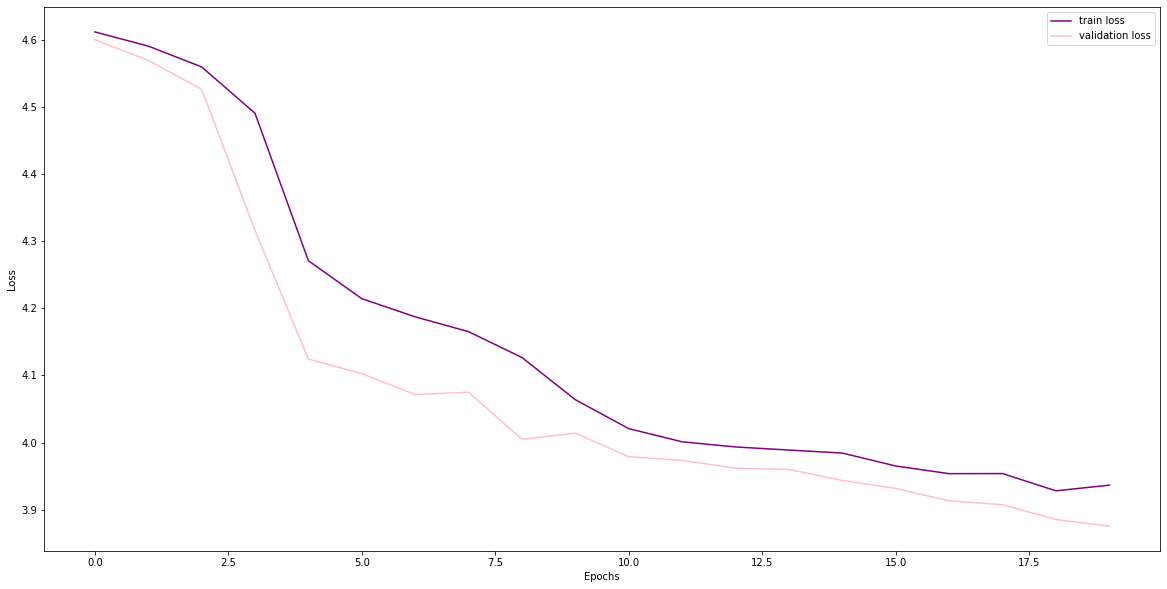

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(train_loss, color='purple', label='train loss')
plt.plot(val_loss,color='pink',label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

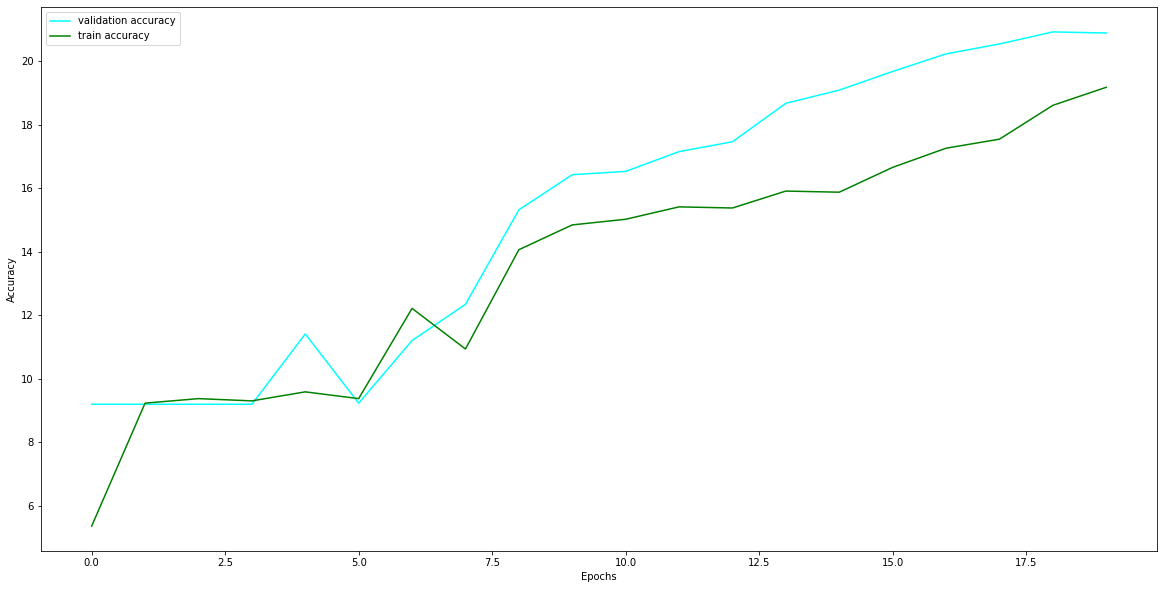

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(val_accuracy, color='cyan', label='validation accuracy')
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
def test (net):
  print('Testing')
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode
  
  corrects=0
  

  with torch.no_grad():
    for images, labels in tqdm(test_dataloader):

      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

  # Forward Pass
      outputs = net(images)

  # Get predictions
      _, preds = torch.max(outputs.data, 1)

  # Update Corrects
      corrects += torch.sum(preds == labels.data).data.item()
  
  # Calculate Accuracy
  accuracy = corrects / float(len(test_dataset))

  

  return accuracy

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 20     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10     # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [ ]:
 #Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY,nesterov=True)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [ ]:
start = time.time()
train_loss, val_loss, train_accuracy, val_accuracy = fit(net)

end = time.time()

print((end-start)/60, 'minutes')

Starting epoch 1/20, LR = [0.001]
Step 0, Loss 4.625336170196533
Step 10, Loss 4.623459815979004
Validating



Validation Accuracy: 0.8644536652835408

Starting epoch 2/20, LR = [0.001]
Step 20, Loss 4.6222920417785645
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 3/20, LR = [0.001]
Step 30, Loss 4.6176228523254395
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 4/20, LR = [0.001]
Step 40, Loss 4.616159915924072
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 5/20, LR = [0.001]
Step 50, Loss 4.612910270690918
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 6/20, LR = [0.001]
Step 60, Loss 4.6071295738220215
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 7/20, LR = [0.001]
Step 70, Loss 4.609053611755371
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 8/20, LR = [0.001]
Step 80, Loss 4.606838703155518
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 9/20, LR = [0.001]
Step 90, Loss 4.602034091949463
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 10/20, LR = [0.001]
Step 100, Loss 4.597905158996582
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 11/20, LR = [0.0001]
Step 110, Loss 4.591320991516113
Step 120, Loss 4.597316741943359
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 12/20, LR = [0.0001]
Step 130, Loss 4.5933756828308105
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 13/20, LR = [0.0001]
Step 140, Loss 4.590641498565674
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 14/20, LR = [0.0001]
Step 150, Loss 4.592700958251953
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 15/20, LR = [0.0001]
Step 160, Loss 4.597115993499756
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 16/20, LR = [0.0001]
Step 170, Loss 4.589380264282227
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 17/20, LR = [0.0001]
Step 180, Loss 4.595156192779541
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 18/20, LR = [0.0001]
Step 190, Loss 4.59773063659668
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 19/20, LR = [0.0001]
Step 200, Loss 4.593466758728027
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 20/20, LR = [0.0001]
Step 210, Loss 4.589693546295166
Validating



Validation Accuracy: 9.197786998616873

7.14328004916509 minutes


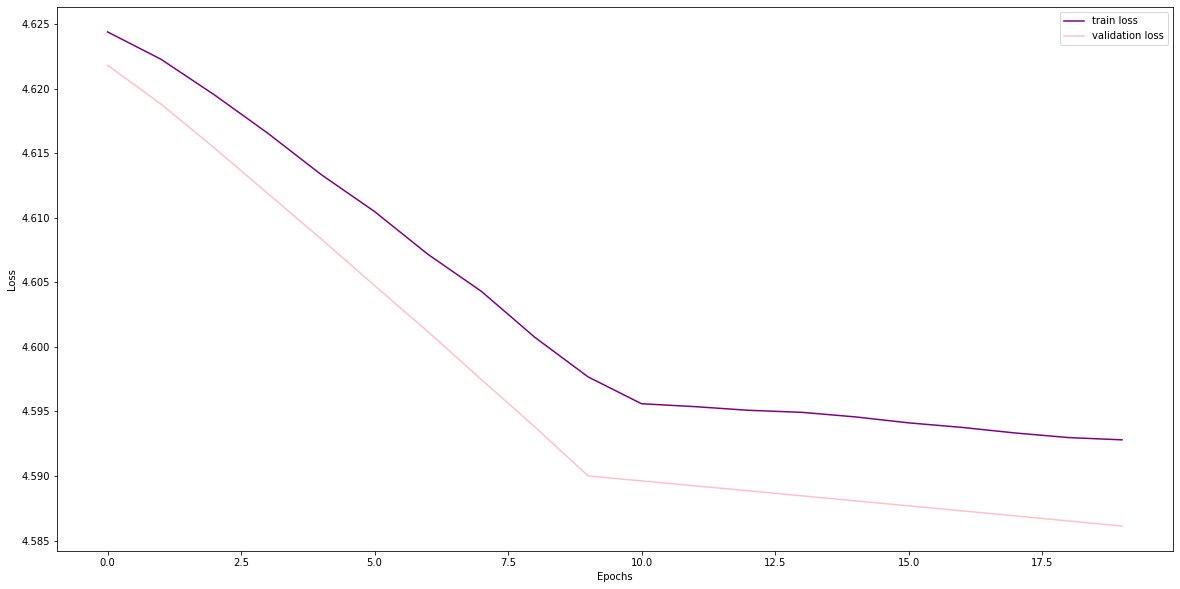

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(train_loss, color='purple', label='train loss')
plt.plot(val_loss,color='pink',label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

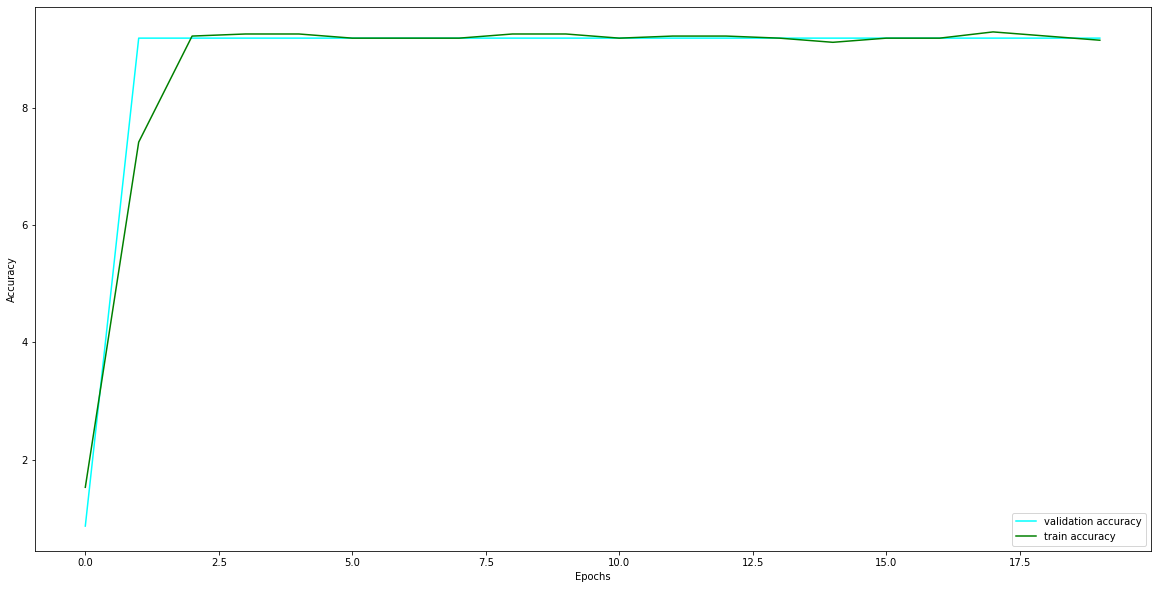

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(val_accuracy, color='cyan', label='validation accuracy')
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Weight decay optimization

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-4  # Regularization, you can keep this at the default

NUM_EPOCHS = 20     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10     # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [ ]:
#Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY,nesterov=True)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [ ]:
start = time.time()
train_loss, val_loss, train_accuracy, val_accuracy = fit(net)

end = time.time()

print((end-start)/60, 'minutes')

Starting epoch 1/20, LR = [0.01]
Step 0, Loss 4.592333793640137
Step 10, Loss 4.575106143951416
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 2/20, LR = [0.01]
Step 20, Loss 4.525583267211914
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 3/20, LR = [0.01]
Step 30, Loss 4.321163654327393
Validating



Validation Accuracy: 11.929460580912863

Starting epoch 4/20, LR = [0.01]
Step 40, Loss 4.252877712249756
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 5/20, LR = [0.01]
Step 50, Loss 4.2547926902771
Validating



Validation Accuracy: 11.341632088520056

Starting epoch 6/20, LR = [0.01]
Step 60, Loss 4.099499225616455
Validating



Validation Accuracy: 14.107883817427386

Starting epoch 7/20, LR = [0.01]
Step 70, Loss 4.1166911125183105
Validating



Validation Accuracy: 16.35546334716459

Starting epoch 8/20, LR = [0.01]
Step 80, Loss 3.9745724201202393
Validating



Validation Accuracy: 18.81051175656985

Starting epoch 9/20, LR = [0.01]
Step 90, Loss 4.01723051071167
Validating



Validation Accuracy: 19.64038727524205

Starting epoch 10/20, LR = [0.01]
Step 100, Loss 3.8585259914398193
Validating



Validation Accuracy: 21.57676348547718

Starting epoch 11/20, LR = [0.001]
Step 110, Loss 3.775367021560669
Step 120, Loss 3.872763156890869
Validating



Validation Accuracy: 21.991701244813278

Starting epoch 12/20, LR = [0.001]
Step 130, Loss 3.622023105621338
Validating



Validation Accuracy: 22.199170124481327

Starting epoch 13/20, LR = [0.001]
Step 140, Loss 3.647360324859619
Validating



Validation Accuracy: 22.406639004149376

Starting epoch 14/20, LR = [0.001]
Step 150, Loss 3.615809917449951
Validating



Validation Accuracy: 22.47579529737206

Starting epoch 15/20, LR = [0.001]
Step 160, Loss 3.7323548793792725
Validating



Validation Accuracy: 22.510373443983404

Starting epoch 16/20, LR = [0.001]
Step 170, Loss 3.7787058353424072
Validating



Validation Accuracy: 22.959889349930844

Starting epoch 17/20, LR = [0.001]
Step 180, Loss 3.7310187816619873
Validating



Validation Accuracy: 22.925311203319502

Starting epoch 18/20, LR = [0.001]
Step 190, Loss 3.8202085494995117
Validating



Validation Accuracy: 23.409405255878283

Starting epoch 19/20, LR = [0.001]
Step 200, Loss 3.486250400543213
Validating



Validation Accuracy: 23.09820193637621

Starting epoch 20/20, LR = [0.001]
Step 210, Loss 3.782271385192871
Validating



Validation Accuracy: 23.443983402489625

7.307453501224518 minutes


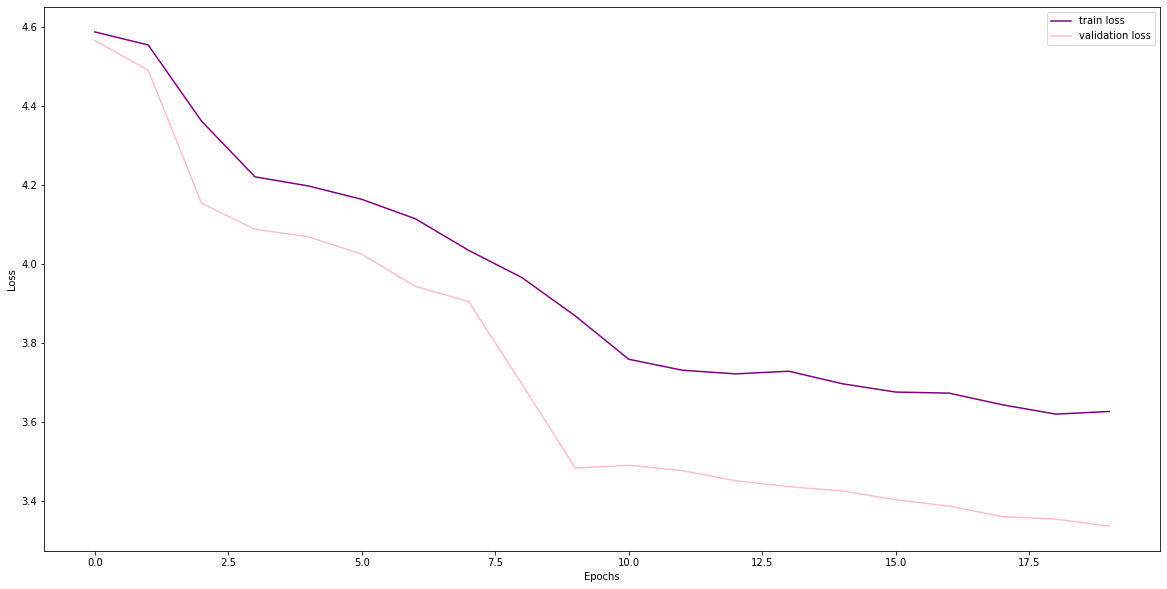

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(train_loss, color='purple', label='train loss')
plt.plot(val_loss,color='pink',label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

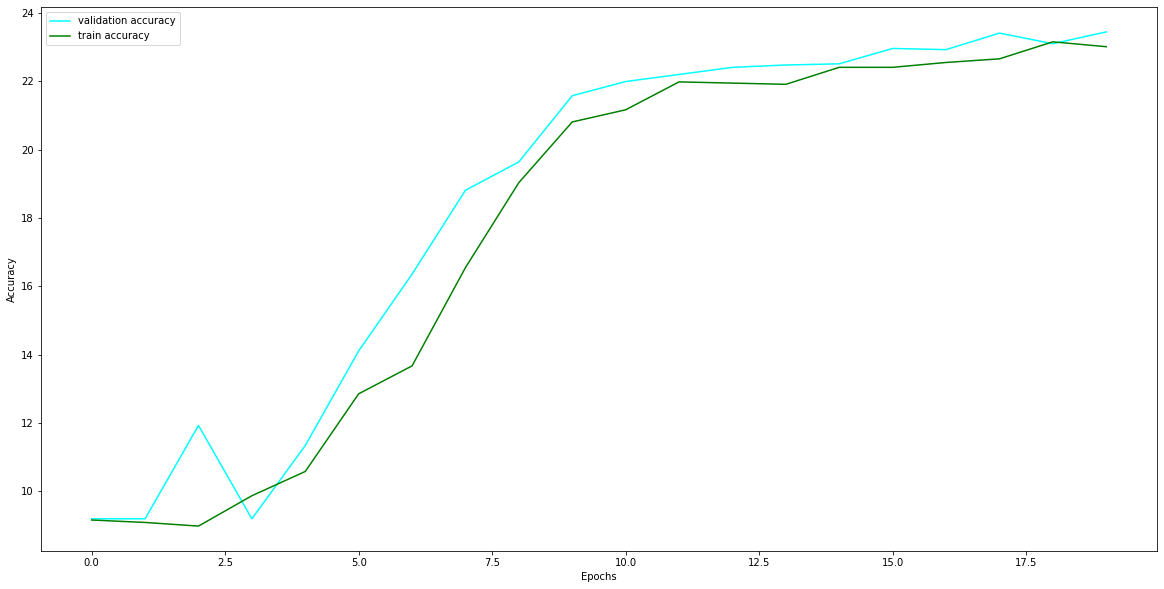

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(val_accuracy, color='cyan', label='validation accuracy')
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-6  # Regularization, you can keep this at the default

NUM_EPOCHS = 20     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10     # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [ ]:
#Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY,nesterov=True)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [ ]:
start = time.time()
train_loss, val_loss, train_accuracy, val_accuracy = fit(net)

end = time.time()

print((end-start)/60, 'minutes')

Starting epoch 1/20, LR = [0.01]
Step 0, Loss 4.6258134841918945
Step 10, Loss 4.613707542419434
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 2/20, LR = [0.01]
Step 20, Loss 4.592582702636719
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 3/20, LR = [0.01]
Step 30, Loss 4.565626621246338
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 4/20, LR = [0.01]
Step 40, Loss 4.524970531463623
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 5/20, LR = [0.01]
Step 50, Loss 4.2945051193237305
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 6/20, LR = [0.01]
Step 60, Loss 4.255814552307129
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 7/20, LR = [0.01]
Step 70, Loss 4.215707778930664
Validating



Validation Accuracy: 15.491009681881051

Starting epoch 8/20, LR = [0.01]
Step 80, Loss 4.2624993324279785
Validating



Validation Accuracy: 14.453665283540802

Starting epoch 9/20, LR = [0.01]
Step 90, Loss 4.193907737731934
Validating



Validation Accuracy: 15.04149377593361

Starting epoch 10/20, LR = [0.01]
Step 100, Loss 4.037158012390137
Validating



Validation Accuracy: 16.666666666666668

Starting epoch 11/20, LR = [0.001]
Step 110, Loss 3.9287593364715576
Step 120, Loss 4.041525840759277
Validating



Validation Accuracy: 18.188105117565698

Starting epoch 12/20, LR = [0.001]
Step 130, Loss 4.093791961669922
Validating



Validation Accuracy: 17.842323651452283

Starting epoch 13/20, LR = [0.001]
Step 140, Loss 3.8377509117126465
Validating



Validation Accuracy: 18.533886583679116

Starting epoch 14/20, LR = [0.001]
Step 150, Loss 3.958448648452759
Validating



Validation Accuracy: 19.363762102351313

Starting epoch 15/20, LR = [0.001]
Step 160, Loss 4.097954273223877
Validating



Validation Accuracy: 19.32918395573997

Starting epoch 16/20, LR = [0.001]
Step 170, Loss 3.8832571506500244
Validating



Validation Accuracy: 19.91701244813278

Starting epoch 17/20, LR = [0.001]
Step 180, Loss 3.9382095336914062
Validating



Validation Accuracy: 19.847856154910097

Starting epoch 18/20, LR = [0.001]
Step 190, Loss 3.877758264541626
Validating



Validation Accuracy: 19.778699861687414

Starting epoch 19/20, LR = [0.001]
Step 200, Loss 4.015160083770752
Validating



Validation Accuracy: 20.055325034578146

Starting epoch 20/20, LR = [0.001]
Step 210, Loss 3.7182960510253906
Validating



Validation Accuracy: 20.228215767634854

6.927840177218119 minutes


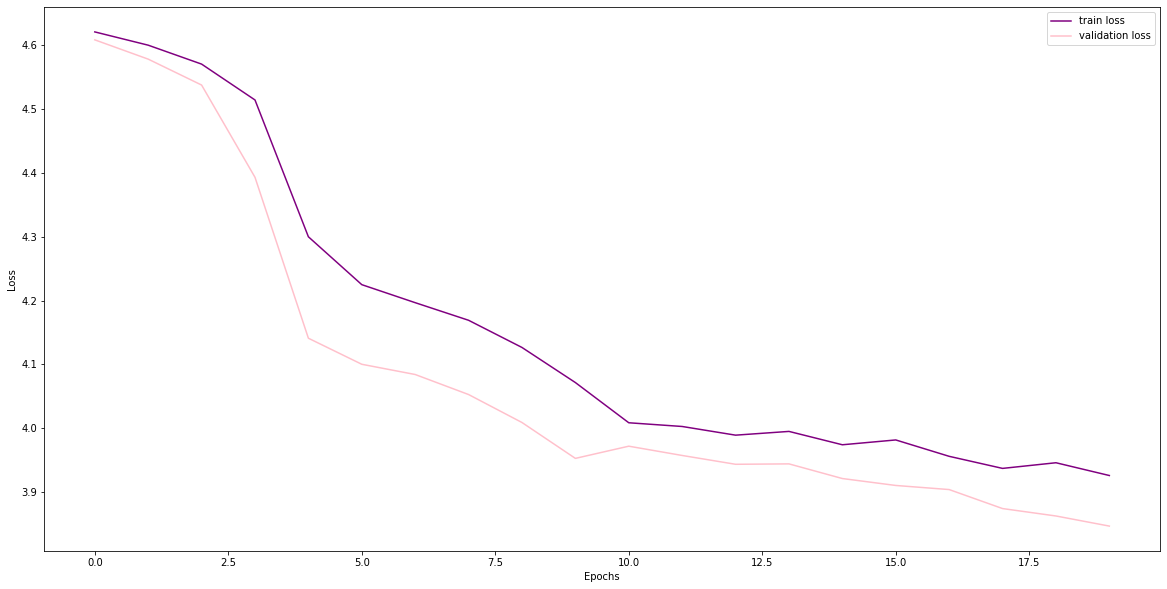

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(train_loss, color='purple', label='train loss')
plt.plot(val_loss,color='pink',label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

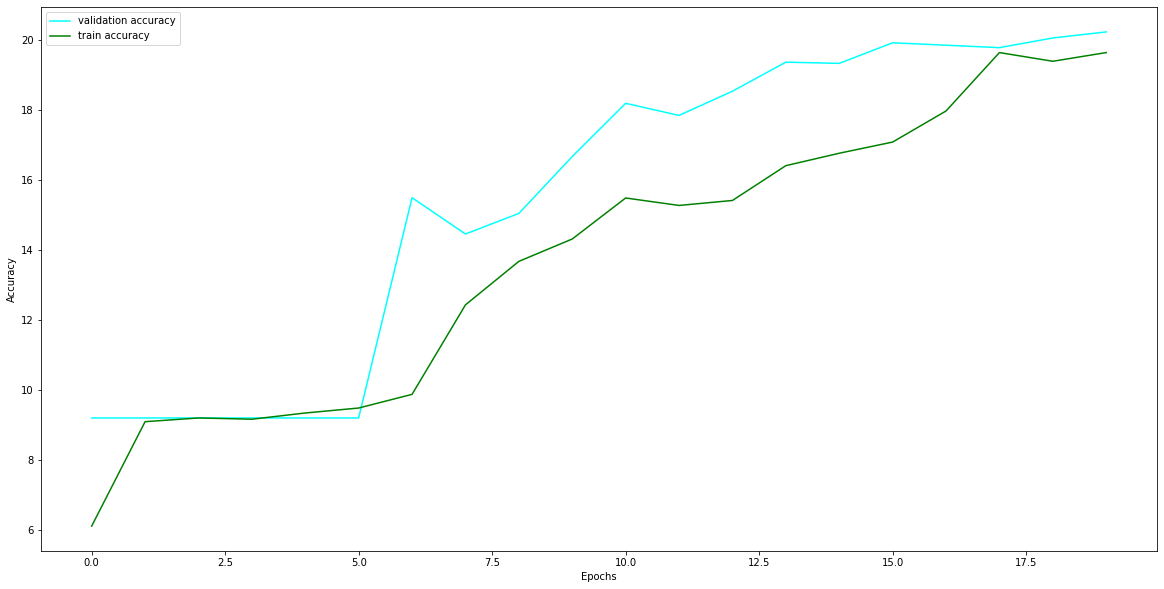

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(val_accuracy, color='cyan', label='validation accuracy')
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Step-Size optimization

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-4  # Regularization, you can keep this at the default

NUM_EPOCHS = 20     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 15     # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [ ]:
#Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY,nesterov=True)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [ ]:
start = time.time()
train_loss, val_loss, train_accuracy, val_accuracy = fit(net)

end = time.time()

print((end-start)/60, 'minutes')

Starting epoch 1/20, LR = [0.01]
Step 0, Loss 4.62687873840332
Step 10, Loss 4.61106538772583
Validating



Validation Accuracy: 9.232365145228215

Starting epoch 2/20, LR = [0.01]
Step 20, Loss 4.591528415679932
Validating



Validation Accuracy: 12.828492392807746

Starting epoch 3/20, LR = [0.01]
Step 30, Loss 4.5493621826171875
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 4/20, LR = [0.01]
Step 40, Loss 4.3645734786987305
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 5/20, LR = [0.01]
Step 50, Loss 4.212193012237549
Validating



Validation Accuracy: 9.474412171507607

Starting epoch 6/20, LR = [0.01]
Step 60, Loss 4.182521820068359
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 7/20, LR = [0.01]
Step 70, Loss 4.120721817016602
Validating



Validation Accuracy: 14.315352697095436

Starting epoch 8/20, LR = [0.01]
Step 80, Loss 3.9090096950531006
Validating



Validation Accuracy: 16.044260027662517

Starting epoch 9/20, LR = [0.01]
Step 90, Loss 4.215300559997559
Validating



Validation Accuracy: 18.672199170124482

Starting epoch 10/20, LR = [0.01]
Step 100, Loss 3.9945907592773438
Validating



Validation Accuracy: 19.398340248962654

Starting epoch 11/20, LR = [0.01]
Step 110, Loss 3.9444327354431152
Step 120, Loss 3.8182570934295654
Validating



Validation Accuracy: 22.06085753803596

Starting epoch 12/20, LR = [0.01]
Step 130, Loss 3.805742025375366
Validating



Validation Accuracy: 22.130013831258644

Starting epoch 13/20, LR = [0.01]
Step 140, Loss 3.590256929397583
Validating



Validation Accuracy: 20.262793914246195

Starting epoch 14/20, LR = [0.01]
Step 150, Loss 3.695084571838379
Validating



Validation Accuracy: 23.96265560165975

Starting epoch 15/20, LR = [0.01]
Step 160, Loss 3.2902026176452637
Validating



Validation Accuracy: 25.44951590594744

Starting epoch 16/20, LR = [0.001]
Step 170, Loss 3.4373276233673096
Validating



Validation Accuracy: 25.899031811894883

Starting epoch 17/20, LR = [0.001]
Step 180, Loss 3.385420560836792
Validating



Validation Accuracy: 25.968188105117566

Starting epoch 18/20, LR = [0.001]
Step 190, Loss 3.4531688690185547
Validating



Validation Accuracy: 25.968188105117566

Starting epoch 19/20, LR = [0.001]
Step 200, Loss 3.367572069168091
Validating



Validation Accuracy: 26.348547717842322

Starting epoch 20/20, LR = [0.001]
Step 210, Loss 3.258958339691162
Validating



Validation Accuracy: 26.31396957123098

6.7295946399370825 minutes


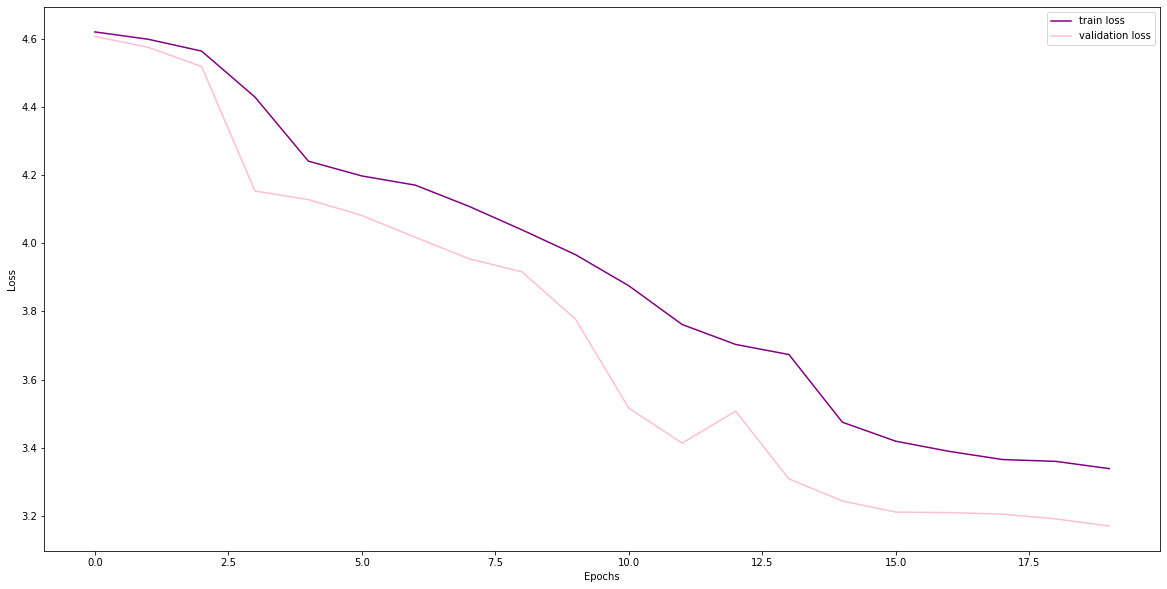

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(train_loss, color='purple', label='train loss')
plt.plot(val_loss,color='pink',label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

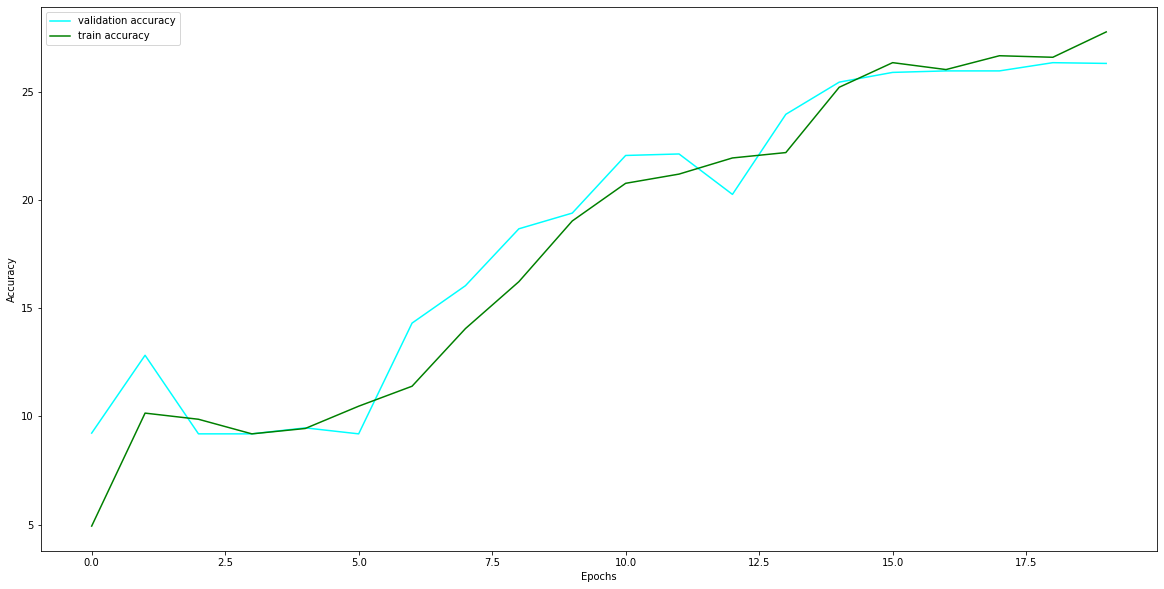

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(val_accuracy, color='cyan', label='validation accuracy')
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-4  # Regularization, you can keep this at the default

NUM_EPOCHS = 20     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 5     # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [ ]:
#Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY,nesterov=True)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [ ]:
start = time.time()
train_loss, val_loss, train_accuracy, val_accuracy = fit(net)

end = time.time()

print((end-start)/60, 'minutes')

Starting epoch 1/20, LR = [0.01]
Step 0, Loss 4.623291969299316
Step 10, Loss 4.611907958984375
Validating



Validation Accuracy: 9.232365145228215

Starting epoch 2/20, LR = [0.01]
Step 20, Loss 4.586971282958984
Validating



Validation Accuracy: 9.336099585062241

Starting epoch 3/20, LR = [0.01]
Step 30, Loss 4.550107955932617
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 4/20, LR = [0.01]
Step 40, Loss 4.463975429534912
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 5/20, LR = [0.01]
Step 50, Loss 4.267247676849365
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 6/20, LR = [0.001]
Step 60, Loss 4.277000427246094
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 7/20, LR = [0.001]
Step 70, Loss 4.176255702972412
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 8/20, LR = [0.001]
Step 80, Loss 4.22010612487793
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 9/20, LR = [0.001]
Step 90, Loss 4.170948028564453
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 10/20, LR = [0.001]
Step 100, Loss 4.0824875831604
Validating



Validation Accuracy: 9.232365145228215

Starting epoch 11/20, LR = [0.0001]
Step 110, Loss 4.209466457366943
Step 120, Loss 4.132915496826172
Validating



Validation Accuracy: 9.232365145228215

Starting epoch 12/20, LR = [0.0001]
Step 130, Loss 4.144574165344238
Validating



Validation Accuracy: 9.3015214384509

Starting epoch 13/20, LR = [0.0001]
Step 140, Loss 4.168600559234619
Validating



Validation Accuracy: 9.336099585062241

Starting epoch 14/20, LR = [0.0001]
Step 150, Loss 4.240477561950684
Validating



Validation Accuracy: 9.336099585062241

Starting epoch 15/20, LR = [0.0001]
Step 160, Loss 4.102247714996338
Validating



Validation Accuracy: 9.370677731673583

Starting epoch 16/20, LR = [1e-05]
Step 170, Loss 4.165729999542236
Validating



Validation Accuracy: 9.370677731673583

Starting epoch 17/20, LR = [1e-05]
Step 180, Loss 4.273365497589111
Validating



Validation Accuracy: 9.370677731673583

Starting epoch 18/20, LR = [1e-05]
Step 190, Loss 4.278876304626465
Validating



Validation Accuracy: 9.370677731673583

Starting epoch 19/20, LR = [1e-05]
Step 200, Loss 4.207677364349365
Validating



Validation Accuracy: 9.370677731673583

Starting epoch 20/20, LR = [1e-05]
Step 210, Loss 4.267307758331299
Validating



Validation Accuracy: 9.370677731673583

6.788981632391612 minutes


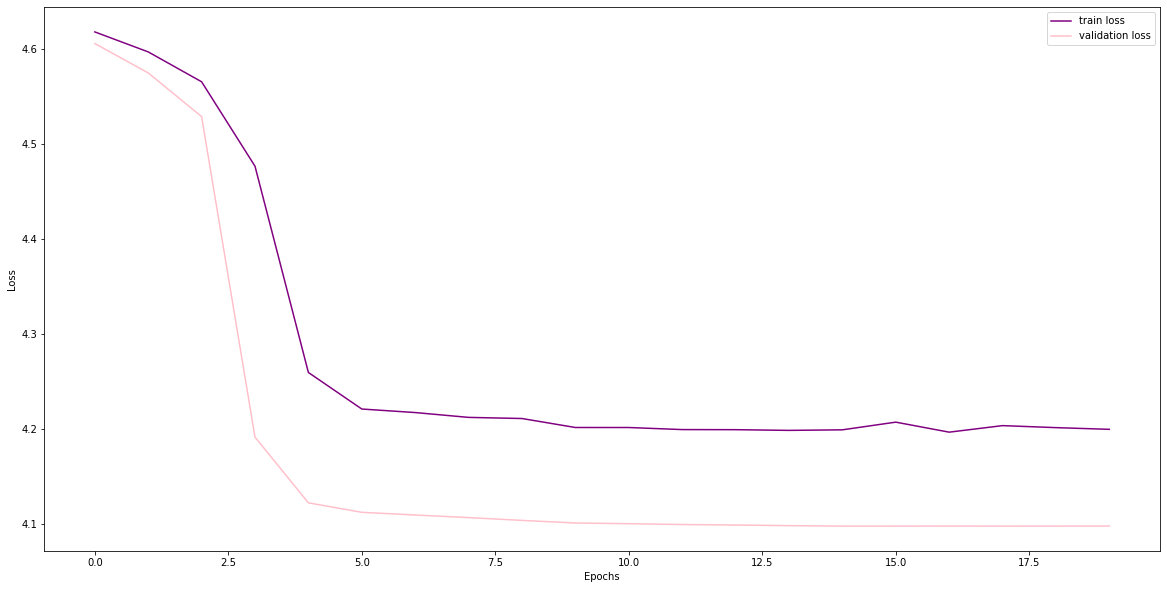

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(train_loss, color='purple', label='train loss')
plt.plot(val_loss,color='pink',label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

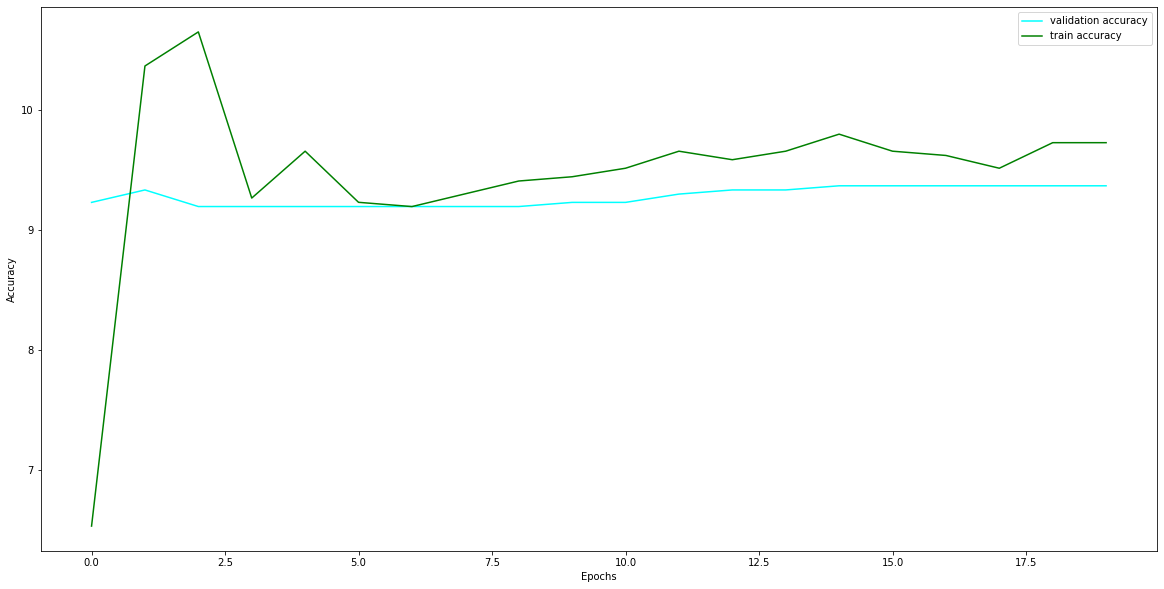

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(val_accuracy, color='cyan', label='validation accuracy')
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Decay rate (Gamma) optimization

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-4  # Regularization, you can keep this at the default

NUM_EPOCHS = 20     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 15     # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.2          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [ ]:
#Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY,nesterov=True)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [ ]:
start = time.time()
train_loss, val_loss, train_accuracy, val_accuracy = fit(net)

end = time.time()

print((end-start)/60, 'minutes')

Starting epoch 1/20, LR = [0.01]
Step 0, Loss 4.628288269042969
Step 10, Loss 4.6141228675842285
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 2/20, LR = [0.01]
Step 20, Loss 4.593163967132568
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 3/20, LR = [0.01]
Step 30, Loss 4.551913738250732
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 4/20, LR = [0.01]
Step 40, Loss 4.462531089782715
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 5/20, LR = [0.01]
Step 50, Loss 4.295986175537109
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 6/20, LR = [0.01]
Step 60, Loss 4.234166622161865
Validating



Validation Accuracy: 15.491009681881051

Starting epoch 7/20, LR = [0.01]
Step 70, Loss 4.248116493225098
Validating



Validation Accuracy: 15.733056708160442

Starting epoch 8/20, LR = [0.01]
Step 80, Loss 4.210297584533691
Validating



Validation Accuracy: 15.629322268326417

Starting epoch 9/20, LR = [0.01]
Step 90, Loss 4.162649631500244
Validating



Validation Accuracy: 16.32088520055325

Starting epoch 10/20, LR = [0.01]
Step 100, Loss 4.091930866241455
Validating



Validation Accuracy: 21.369294605809127

Starting epoch 11/20, LR = [0.01]
Step 110, Loss 3.962562322616577
Step 120, Loss 4.007296562194824
Validating



Validation Accuracy: 21.127247579529737

Starting epoch 12/20, LR = [0.01]
Step 130, Loss 4.0243239402771
Validating



Validation Accuracy: 20.573997233748273

Starting epoch 13/20, LR = [0.01]
Step 140, Loss 3.7195680141448975
Validating



Validation Accuracy: 20.089903181189488

Starting epoch 14/20, LR = [0.01]
Step 150, Loss 3.650805950164795
Validating



Validation Accuracy: 23.616874135546336

Starting epoch 15/20, LR = [0.01]
Step 160, Loss 3.5960419178009033
Validating



Validation Accuracy: 24.654218533886585

Starting epoch 16/20, LR = [0.002]
Step 170, Loss 3.456103563308716
Validating



Validation Accuracy: 25.0

Starting epoch 17/20, LR = [0.002]
Step 180, Loss 3.494507312774658
Validating



Validation Accuracy: 25.172890733056708

Starting epoch 18/20, LR = [0.002]
Step 190, Loss 3.2516896724700928
Validating



Validation Accuracy: 25.518672199170126

Starting epoch 19/20, LR = [0.002]
Step 200, Loss 3.3020970821380615
Validating



Validation Accuracy: 25.656984785615492

Starting epoch 20/20, LR = [0.002]
Step 210, Loss 3.312450408935547
Validating



Validation Accuracy: 25.86445366528354

7.087158477306366 minutes


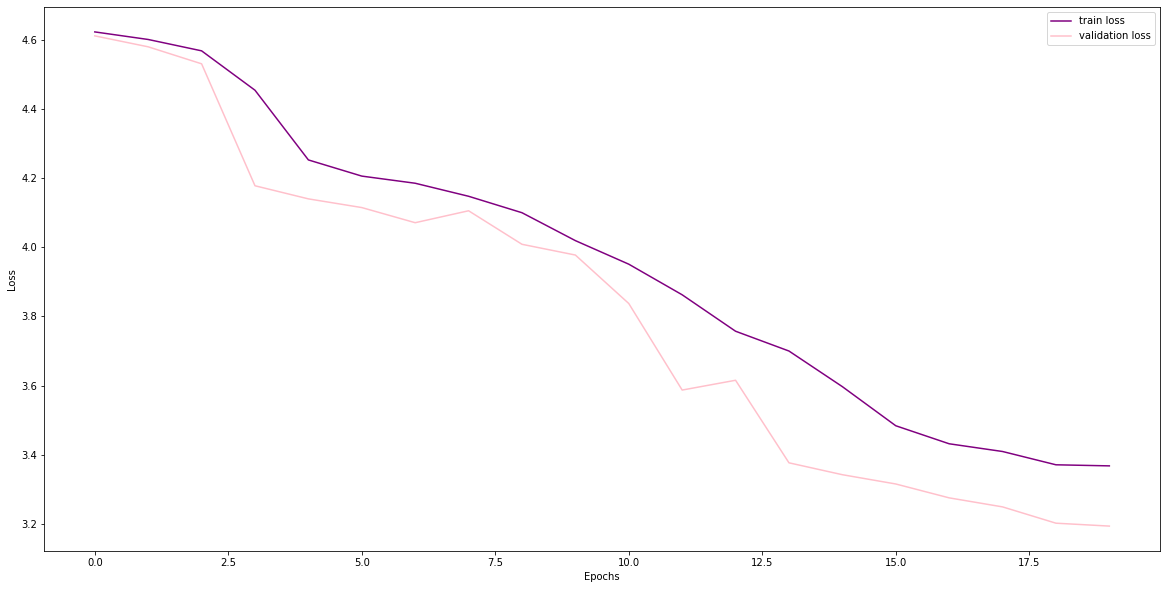

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(train_loss, color='purple', label='train loss')
plt.plot(val_loss,color='pink',label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

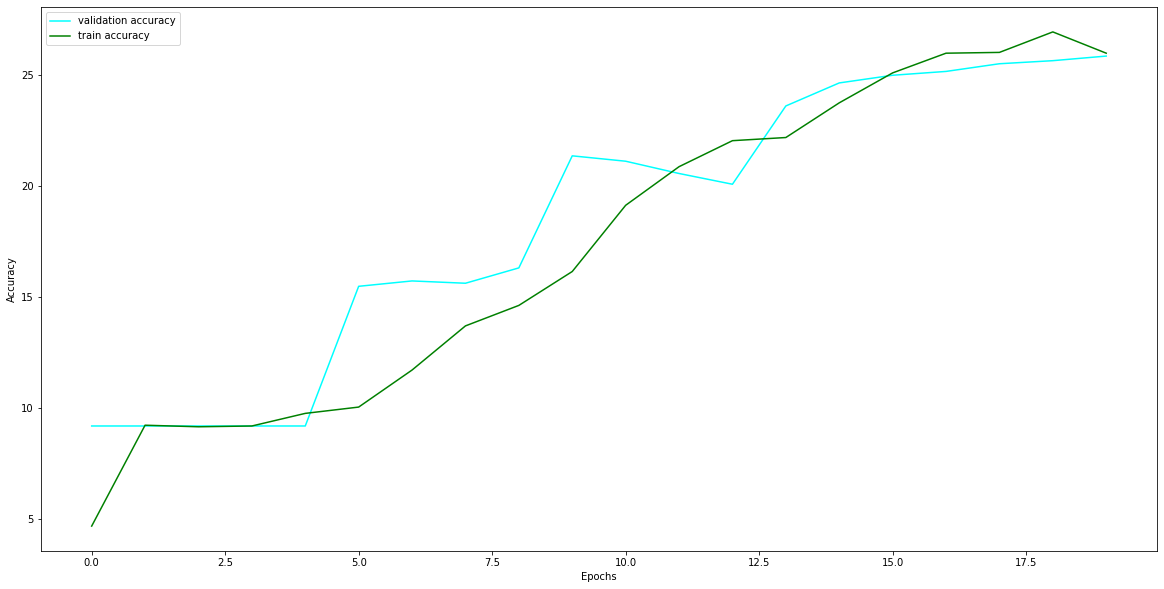

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(val_accuracy, color='cyan', label='validation accuracy')
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-4  # Regularization, you can keep this at the default

NUM_EPOCHS = 20     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 15     # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.3          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [ ]:
#Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY,nesterov=True)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [ ]:
start = time.time()
train_loss, val_loss, train_accuracy, val_accuracy = fit(net)

end = time.time()

print((end-start)/60, 'minutes')

Starting epoch 1/20, LR = [0.01]
Step 0, Loss 4.624454498291016
Step 10, Loss 4.613389492034912
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 2/20, LR = [0.01]
Step 20, Loss 4.585830211639404
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 3/20, LR = [0.01]
Step 30, Loss 4.560901641845703
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 4/20, LR = [0.01]
Step 40, Loss 4.457475185394287
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 5/20, LR = [0.01]
Step 50, Loss 4.243226528167725
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 6/20, LR = [0.01]
Step 60, Loss 4.266139030456543
Validating



Validation Accuracy: 13.278008298755188

Starting epoch 7/20, LR = [0.01]
Step 70, Loss 4.1337127685546875
Validating



Validation Accuracy: 15.04149377593361

Starting epoch 8/20, LR = [0.01]
Step 80, Loss 4.151675701141357
Validating



Validation Accuracy: 16.009681881051176

Starting epoch 9/20, LR = [0.01]
Step 90, Loss 3.976740837097168
Validating



Validation Accuracy: 19.121715076071922

Starting epoch 10/20, LR = [0.01]
Step 100, Loss 4.12410306930542
Validating



Validation Accuracy: 19.91701244813278

Starting epoch 11/20, LR = [0.01]
Step 110, Loss 3.9491286277770996
Step 120, Loss 3.8933467864990234
Validating



Validation Accuracy: 20.677731673582297

Starting epoch 12/20, LR = [0.01]
Step 130, Loss 3.611015796661377
Validating



Validation Accuracy: 21.922544951590595

Starting epoch 13/20, LR = [0.01]
Step 140, Loss 3.6376869678497314
Validating



Validation Accuracy: 23.167358229598893

Starting epoch 14/20, LR = [0.01]
Step 150, Loss 3.695873260498047
Validating



Validation Accuracy: 23.96265560165975

Starting epoch 15/20, LR = [0.01]
Step 160, Loss 3.713679552078247
Validating



Validation Accuracy: 24.723374827109268

Starting epoch 16/20, LR = [0.003]
Step 170, Loss 3.609736919403076
Validating



Validation Accuracy: 25.760719225449517

Starting epoch 17/20, LR = [0.003]
Step 180, Loss 3.496983051300049
Validating



Validation Accuracy: 25.656984785615492

Starting epoch 18/20, LR = [0.003]
Step 190, Loss 3.4051513671875
Validating



Validation Accuracy: 26.798063623789766

Starting epoch 19/20, LR = [0.003]
Step 200, Loss 3.2765910625457764
Validating



Validation Accuracy: 26.48686030428769

Starting epoch 20/20, LR = [0.003]
Step 210, Loss 3.239363431930542
Validating



Validation Accuracy: 27.282157676348547

6.973922876516978 minutes


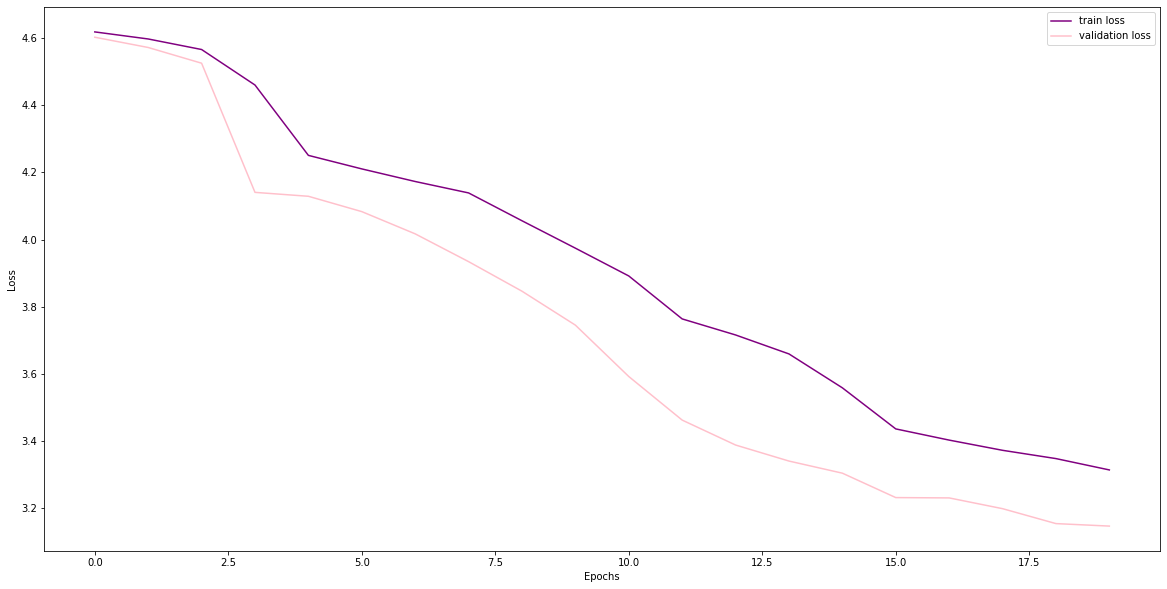

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(train_loss, color='purple', label='train loss')
plt.plot(val_loss,color='pink',label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

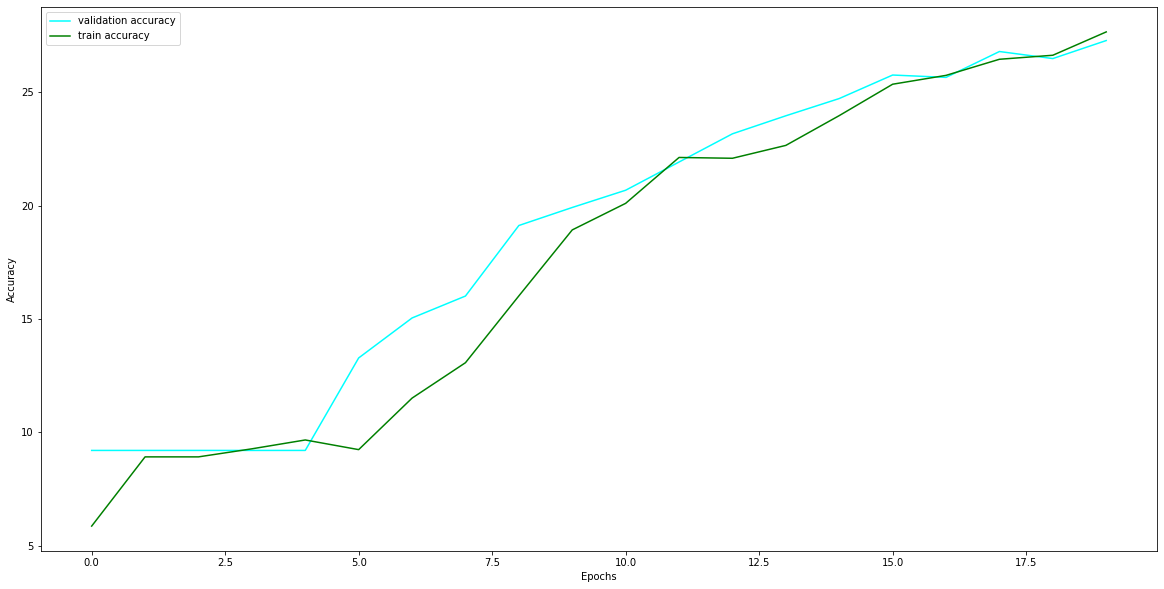

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(val_accuracy, color='cyan', label='validation accuracy')
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Best model on the test set

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-4  # Regularization, you can keep this at the default

NUM_EPOCHS = 20     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 15     # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.3         # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [ ]:
#Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY,nesterov=True)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [ ]:
start = time.time()
train_loss, val_loss, train_accuracy, val_accuracy = fit(net)

end = time.time()

print((end-start)/60, 'minutes')

Starting epoch 1/20, LR = [0.01]
Step 0, Loss 4.615383625030518
Step 10, Loss 4.603333473205566
Validating



Validation Accuracy: 9.232365145228215

Starting epoch 2/20, LR = [0.01]
Step 20, Loss 4.587895393371582
Validating



Validation Accuracy: 10.719225449515905

Starting epoch 3/20, LR = [0.01]
Step 30, Loss 4.539484024047852
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 4/20, LR = [0.01]
Step 40, Loss 4.523488521575928
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 5/20, LR = [0.01]
Step 50, Loss 4.265682697296143
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 6/20, LR = [0.01]
Step 60, Loss 4.167704105377197
Validating



Validation Accuracy: 9.197786998616873

Starting epoch 7/20, LR = [0.01]
Step 70, Loss 4.2811760902404785
Validating



Validation Accuracy: 9.508990318118949

Starting epoch 8/20, LR = [0.01]
Step 80, Loss 4.148573875427246
Validating



Validation Accuracy: 10.61549100968188

Starting epoch 9/20, LR = [0.01]
Step 90, Loss 4.130674839019775
Validating



Validation Accuracy: 16.32088520055325

Starting epoch 10/20, LR = [0.01]
Step 100, Loss 3.978670597076416
Validating



Validation Accuracy: 18.568464730290458

Starting epoch 11/20, LR = [0.01]
Step 110, Loss 4.052395820617676
Step 120, Loss 4.022619247436523
Validating



Validation Accuracy: 19.017980636237898

Starting epoch 12/20, LR = [0.01]
Step 130, Loss 3.6232097148895264
Validating



Validation Accuracy: 20.33195020746888

Starting epoch 13/20, LR = [0.01]
Step 140, Loss 3.771845579147339
Validating



Validation Accuracy: 20.677731673582297

Starting epoch 14/20, LR = [0.01]
Step 150, Loss 3.816715955734253
Validating



Validation Accuracy: 22.164591977869986

Starting epoch 15/20, LR = [0.01]
Step 160, Loss 3.487974166870117
Validating



Validation Accuracy: 21.853388658367912

Starting epoch 16/20, LR = [0.003]
Step 170, Loss 3.4456658363342285
Validating



Validation Accuracy: 24.239280774550483

Starting epoch 17/20, LR = [0.003]
Step 180, Loss 3.6342339515686035
Validating



Validation Accuracy: 23.755186721991702

Starting epoch 18/20, LR = [0.003]
Step 190, Loss 3.491478204727173
Validating



Validation Accuracy: 25.03457814661134

Starting epoch 19/20, LR = [0.003]
Step 200, Loss 3.3560101985931396
Validating



Validation Accuracy: 25.58782849239281

Starting epoch 20/20, LR = [0.003]
Step 210, Loss 3.4675369262695312
Validating



Validation Accuracy: 25.48409405255878

9.499570727348328 minutes


In [ ]:
result = test(net)

print('Accuracy of the network on test images: %0.3f %%' % (100 * result))

Testing



Accuracy of the network on test images: 25.302 %


# TRANSFER LEARNING

## Learning rate optimization




In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 15     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 5      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [ ]:
# Define transforms for training phase
train_transform_transfer = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225]) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform_transfer = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])                                   
])

In [ ]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/davibuss/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'
from Caltech101.caltech_dataset import Caltech


# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform_transfer)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform_transfer)
print(type(train_dataset))
 # split to train val

train_len = int(train_dataset.__len__() * 0.5)
val_len = int(train_dataset.__len__() * 0.5)
train_indexes = np.arange(train_dataset.__len__())
print(train_indexes)
train_labels = np.empty(train_dataset.__len__(), dtype=int)


for index in train_indexes:
  train_labels[index] = train_dataset.__getitem__(index)[1]
print(train_labels)  

train_indexes, val_indexes, _, _ = train_test_split(train_indexes, train_labels, test_size=0.5, random_state=42, stratify=train_labels)


"""
validation_split = 0.5
dataset_size = len(train_dataset)
#print(dataset_size)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if 1 :
    np.random.seed(1337)
    np.random.shuffle(indices)
train_indexes, val_indexes = indices[split:], indices[:split]

print(type(train_indexes))
#train_indexes = SubsetRandomSampler(train_indices)
#val_indexes = SubsetRandomSampler(valid_indices)
#train_indexes, val_indexes = 
#print(type(train_indexes))
#print(train_indexes)
"""

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))


<class 'Caltech101.caltech_dataset.Caltech'>
[   0    1    2 ... 5781 5782 5783]
[  0   0   0 ... 100 100 100]
Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


In [ ]:
transfer=alexnet(pretrained=True).to(DEVICE)

print(type(transfer))
print(transfer)

transfer.classifier[6]=nn.Linear(4096,NUM_CLASSES)

criterion=nn.CrossEntropyLoss()

parameters_to_optimize=transfer.classifier[6].parameters()

optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY,nesterov=True)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



<class 'torchvision.models.alexnet.AlexNet'>
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_

In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(type(train_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
start = time.time()
train_loss, val_loss, train_accuracy, val_accuracy = fit(transfer)

end = time.time()

print((end-start)/60, 'minutes')


Starting epoch 1/15, LR = [0.01]
Step 0, Loss 4.8321146965026855
Step 10, Loss 1.365761637687683
Validating



Validation Accuracy: 69.91701244813278

Starting epoch 2/15, LR = [0.01]
Step 20, Loss 0.5398129224777222
Validating



Validation Accuracy: 80.18672199170125

Starting epoch 3/15, LR = [0.01]
Step 30, Loss 0.3076539933681488
Validating



Validation Accuracy: 80.94744121715075

Starting epoch 4/15, LR = [0.01]
Step 40, Loss 0.23726992309093475
Validating



Validation Accuracy: 82.26141078838174

Starting epoch 5/15, LR = [0.01]
Step 50, Loss 0.16106052696704865
Validating



Validation Accuracy: 81.95020746887967

Starting epoch 6/15, LR = [0.001]
Step 60, Loss 0.10232099890708923
Validating



Validation Accuracy: 82.15767634854772

Starting epoch 7/15, LR = [0.001]
Step 70, Loss 0.11491788923740387
Validating



Validation Accuracy: 82.19225449515906

Starting epoch 8/15, LR = [0.001]
Step 80, Loss 0.10393348336219788
Validating



Validation Accuracy: 82.19225449515906

Starting epoch 9/15, LR = [0.001]
Step 90, Loss 0.09389717131853104
Validating



Validation Accuracy: 82.2268326417704

Starting epoch 10/15, LR = [0.001]
Step 100, Loss 0.1234772801399231
Validating



Validation Accuracy: 82.12309820193637

Starting epoch 11/15, LR = [0.0001]
Step 110, Loss 0.08886555582284927
Step 120, Loss 0.07204407453536987
Validating



Validation Accuracy: 82.12309820193637

Starting epoch 12/15, LR = [0.0001]
Step 130, Loss 0.11794368922710419
Validating



Validation Accuracy: 82.19225449515906

Starting epoch 13/15, LR = [0.0001]
Step 140, Loss 0.10878191143274307
Validating



Validation Accuracy: 82.2268326417704

Starting epoch 14/15, LR = [0.0001]
Step 150, Loss 0.08900899440050125
Validating



Validation Accuracy: 82.26141078838174

Starting epoch 15/15, LR = [0.0001]
Step 160, Loss 0.11240701377391815
Validating



Validation Accuracy: 82.26141078838174

5.522864667574565 minutes


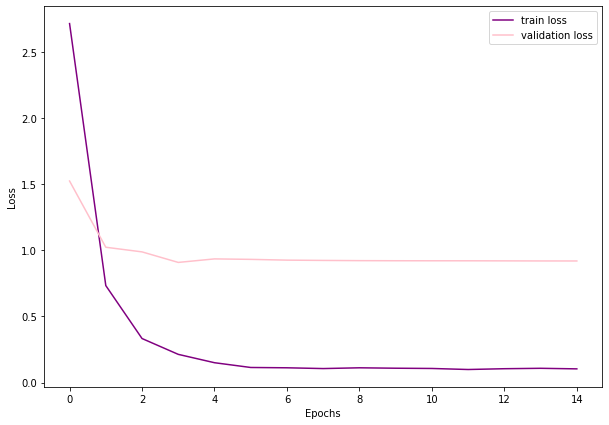

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='purple', label='train loss')
plt.plot(val_loss,color='pink',label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


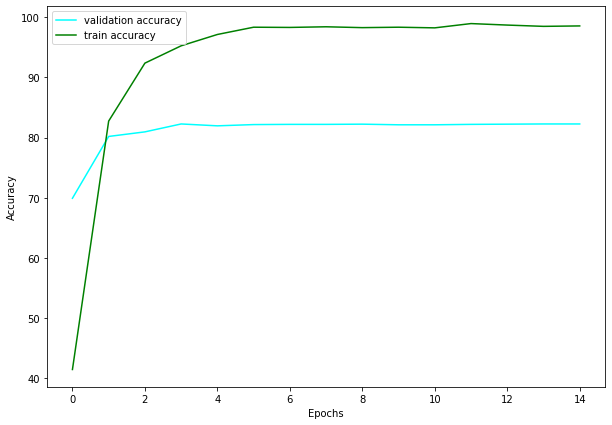

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(val_accuracy, color='cyan', label='validation accuracy')
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 15     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 5      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [ ]:
transfer=alexnet(pretrained=True).to(DEVICE)

print(type(transfer))


transfer.classifier[6]=nn.Linear(4096,NUM_CLASSES)

criterion=nn.CrossEntropyLoss()

parameters_to_optimize=transfer.classifier[6].parameters()

optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY,nesterov=True)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

<class 'torchvision.models.alexnet.AlexNet'>


In [ ]:
start = time.time()
train_loss, val_loss, train_accuracy, val_accuracy = fit(transfer)

end = time.time()

print((end-start)/60, 'minutes')

Starting epoch 1/15, LR = [0.001]
Step 0, Loss 4.86851167678833
Step 10, Loss 3.401376485824585
Validating



Validation Accuracy: 30.94744121715076

Starting epoch 2/15, LR = [0.001]
Step 20, Loss 2.5416202545166016
Validating



Validation Accuracy: 47.89073305670816

Starting epoch 3/15, LR = [0.001]
Step 30, Loss 2.035369873046875
Validating



Validation Accuracy: 59.612724757952975

Starting epoch 4/15, LR = [0.001]
Step 40, Loss 1.717830777168274
Validating



Validation Accuracy: 66.45919778699862

Starting epoch 5/15, LR = [0.001]
Step 50, Loss 1.3026480674743652
Validating



Validation Accuracy: 70.22821576763485

Starting epoch 6/15, LR = [0.0001]
Step 60, Loss 1.0028200149536133
Validating



Validation Accuracy: 70.74688796680498

Starting epoch 7/15, LR = [0.0001]
Step 70, Loss 1.1404145956039429
Validating



Validation Accuracy: 70.78146611341631

Starting epoch 8/15, LR = [0.0001]
Step 80, Loss 1.1286479234695435
Validating



Validation Accuracy: 71.0926694329184

Starting epoch 9/15, LR = [0.0001]
Step 90, Loss 1.1239408254623413
Validating



Validation Accuracy: 71.19640387275243

Starting epoch 10/15, LR = [0.0001]
Step 100, Loss 1.1326229572296143
Validating



Validation Accuracy: 71.5076071922545

Starting epoch 11/15, LR = [1e-05]
Step 110, Loss 1.0683387517929077
Step 120, Loss 1.0739448070526123
Validating



Validation Accuracy: 71.54218533886583

Starting epoch 12/15, LR = [1e-05]
Step 130, Loss 1.1333364248275757
Validating



Validation Accuracy: 71.54218533886583

Starting epoch 13/15, LR = [1e-05]
Step 140, Loss 1.029361605644226
Validating



Validation Accuracy: 71.54218533886583

Starting epoch 14/15, LR = [1e-05]
Step 150, Loss 1.1056158542633057
Validating



Validation Accuracy: 71.54218533886583

Starting epoch 15/15, LR = [1e-05]
Step 160, Loss 1.0892233848571777
Validating



Validation Accuracy: 71.57676348547717

5.4863396803538 minutes


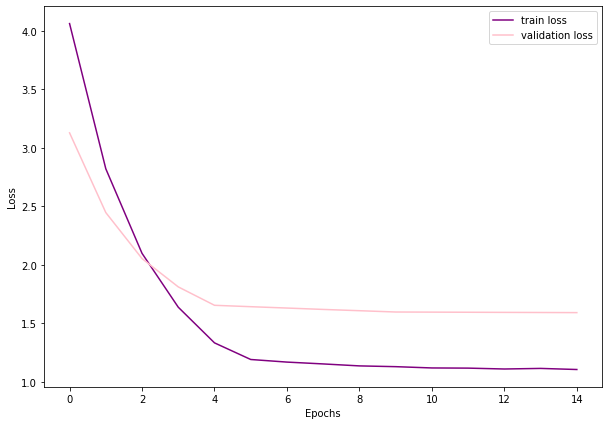

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='purple', label='train loss')
plt.plot(val_loss,color='pink',label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

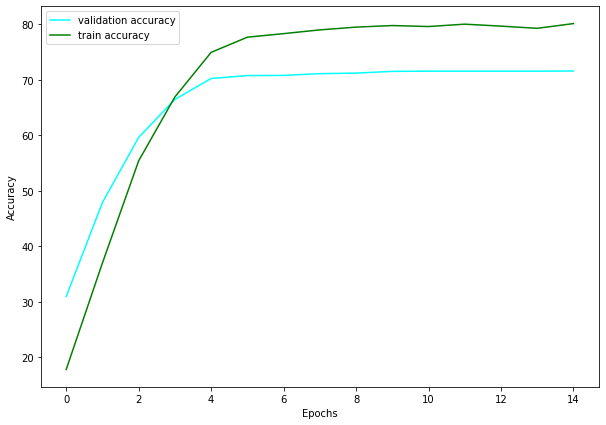

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(val_accuracy, color='cyan', label='validation accuracy')
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-4            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-6  # Regularization, you can keep this at the default

NUM_EPOCHS = 15     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 5      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [ ]:
transfer=alexnet(pretrained=True).to(DEVICE)

print(type(transfer))


transfer.classifier[6]=nn.Linear(4096,NUM_CLASSES)

criterion=nn.CrossEntropyLoss()

parameters_to_optimize=transfer.classifier[6].parameters()

optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY,nesterov=True)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

<class 'torchvision.models.alexnet.AlexNet'>


In [ ]:
start = time.time()
train_loss, val_loss, train_accuracy, val_accuracy = fit(transfer)

end = time.time()

print((end-start)/60, 'minutes')

Starting epoch 1/15, LR = [0.0001]
Step 0, Loss 4.821317672729492
Step 10, Loss 4.641082763671875
Validating



Validation Accuracy: 9.716459197786998

Starting epoch 2/15, LR = [0.0001]
Step 20, Loss 3.994600296020508
Validating



Validation Accuracy: 22.199170124481327

Starting epoch 3/15, LR = [0.0001]
Step 30, Loss 3.6785175800323486
Validating



Validation Accuracy: 24.1701244813278

Starting epoch 4/15, LR = [0.0001]
Step 40, Loss 3.635327100753784
Validating



Validation Accuracy: 26.590594744121717

Starting epoch 5/15, LR = [0.0001]
Step 50, Loss 3.5040624141693115
Validating



Validation Accuracy: 29.356846473029044

Starting epoch 6/15, LR = [1e-05]
Step 60, Loss 3.3369948863983154
Validating



Validation Accuracy: 29.63347164591978

Starting epoch 7/15, LR = [1e-05]
Step 70, Loss 3.185482978820801
Validating



Validation Accuracy: 29.84094052558783

Starting epoch 8/15, LR = [1e-05]
Step 80, Loss 3.1980912685394287
Validating



Validation Accuracy: 30.013831258644537

Starting epoch 9/15, LR = [1e-05]
Step 90, Loss 3.244065046310425
Validating



Validation Accuracy: 30.463347164591976

Starting epoch 10/15, LR = [1e-05]
Step 100, Loss 3.3358542919158936
Validating



Validation Accuracy: 30.601659751037346

Starting epoch 11/15, LR = [1.0000000000000002e-06]
Step 110, Loss 3.3419880867004395
Step 120, Loss 3.357848644256592
Validating



Validation Accuracy: 30.601659751037346

Starting epoch 12/15, LR = [1.0000000000000002e-06]
Step 130, Loss 3.291949987411499
Validating



Validation Accuracy: 30.601659751037346

Starting epoch 13/15, LR = [1.0000000000000002e-06]
Step 140, Loss 3.1979267597198486
Validating



Validation Accuracy: 30.67081604426003

Starting epoch 14/15, LR = [1.0000000000000002e-06]
Step 150, Loss 3.2970657348632812
Validating



Validation Accuracy: 30.70539419087137

Starting epoch 15/15, LR = [1.0000000000000002e-06]
Step 160, Loss 3.2285170555114746
Validating



Validation Accuracy: 30.774550484094053

5.5076240261395775 minutes


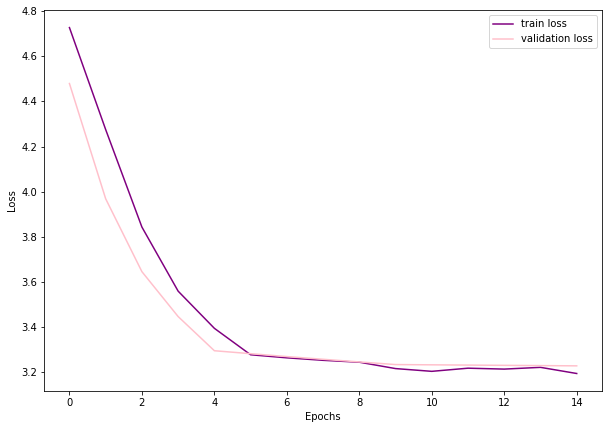

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='purple', label='train loss')
plt.plot(val_loss,color='pink',label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

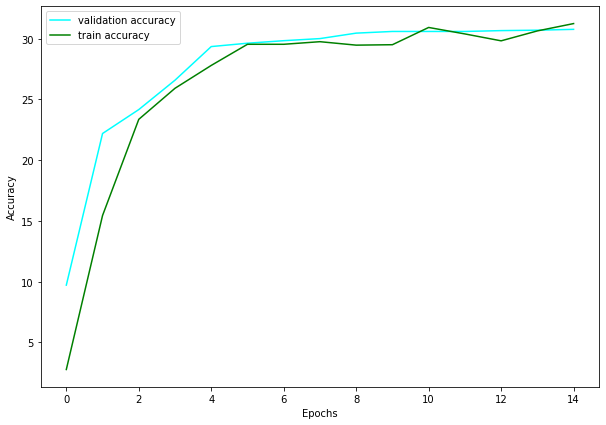

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(val_accuracy, color='cyan', label='validation accuracy')
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Weight decay optimization

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-6  # Regularization, you can keep this at the default

NUM_EPOCHS = 15     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 5      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [ ]:
transfer=alexnet(pretrained=True).to(DEVICE)

print(type(transfer))


transfer.classifier[6]=nn.Linear(4096,NUM_CLASSES)

criterion=nn.CrossEntropyLoss()

parameters_to_optimize=transfer.classifier[6].parameters()

optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY,nesterov=True)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

<class 'torchvision.models.alexnet.AlexNet'>


In [ ]:
start = time.time()
train_loss, val_loss, train_accuracy, val_accuracy = fit(transfer)

end = time.time()

print((end-start)/60, 'minutes')

Starting epoch 1/15, LR = [0.01]
Step 0, Loss 4.884830951690674
Step 10, Loss 1.5022741556167603
Validating



Validation Accuracy: 69.57123098201936

Starting epoch 2/15, LR = [0.01]
Step 20, Loss 0.4998549818992615
Validating



Validation Accuracy: 79.97925311203319

Starting epoch 3/15, LR = [0.01]
Step 30, Loss 0.26301810145378113
Validating



Validation Accuracy: 81.984785615491

Starting epoch 4/15, LR = [0.01]
Step 40, Loss 0.26429104804992676
Validating



Validation Accuracy: 82.29598893499309

Starting epoch 5/15, LR = [0.01]
Step 50, Loss 0.14936883747577667
Validating



Validation Accuracy: 82.4688796680498

Starting epoch 6/15, LR = [0.001]
Step 60, Loss 0.11115109920501709
Validating



Validation Accuracy: 82.36514522821577

Starting epoch 7/15, LR = [0.001]
Step 70, Loss 0.09995725750923157
Validating



Validation Accuracy: 82.3997233748271

Starting epoch 8/15, LR = [0.001]
Step 80, Loss 0.11710803210735321
Validating



Validation Accuracy: 82.53803596127247

Starting epoch 9/15, LR = [0.001]
Step 90, Loss 0.09457585215568542
Validating



Validation Accuracy: 82.60719225449516

Starting epoch 10/15, LR = [0.001]
Step 100, Loss 0.0916740894317627
Validating



Validation Accuracy: 82.53803596127247

Starting epoch 11/15, LR = [0.0001]
Step 110, Loss 0.12403926998376846
Step 120, Loss 0.1105223149061203
Validating



Validation Accuracy: 82.57261410788382

Starting epoch 12/15, LR = [0.0001]
Step 130, Loss 0.10848802328109741
Validating



Validation Accuracy: 82.57261410788382

Starting epoch 13/15, LR = [0.0001]
Step 140, Loss 0.09523478150367737
Validating



Validation Accuracy: 82.60719225449516

Starting epoch 14/15, LR = [0.0001]
Step 150, Loss 0.11191436648368835
Validating



Validation Accuracy: 82.60719225449516

Starting epoch 15/15, LR = [0.0001]
Step 160, Loss 0.10309269279241562
Validating



Validation Accuracy: 82.60719225449516

5.323870877424876 minutes


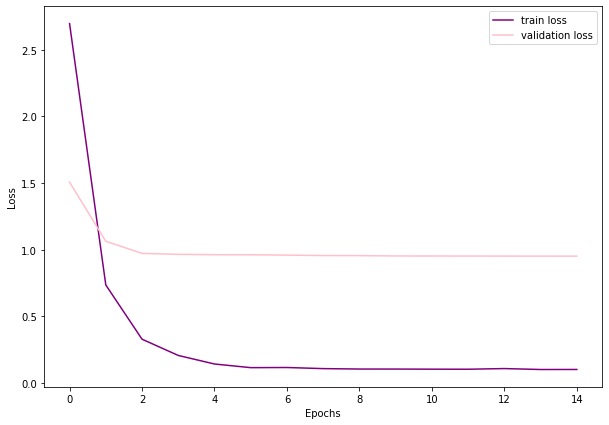

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='purple', label='train loss')
plt.plot(val_loss,color='pink',label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

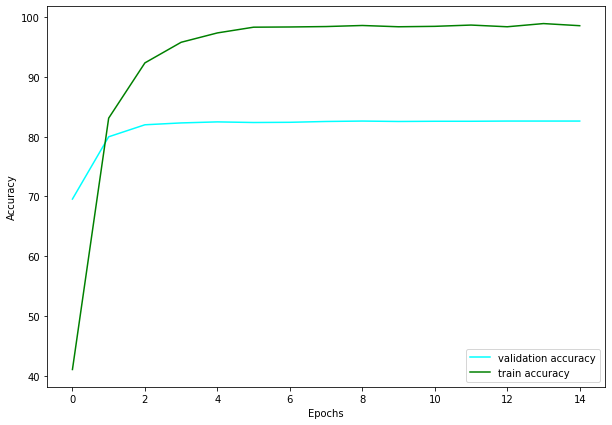

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(val_accuracy, color='cyan', label='validation accuracy')
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-4  # Regularization, you can keep this at the default

NUM_EPOCHS = 15     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 5      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [ ]:
transfer=alexnet(pretrained=True).to(DEVICE)

print(type(transfer))


transfer.classifier[6]=nn.Linear(4096,NUM_CLASSES)

criterion=nn.CrossEntropyLoss()

parameters_to_optimize=transfer.classifier[6].parameters()

optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY,nesterov=True)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

<class 'torchvision.models.alexnet.AlexNet'>


In [ ]:
start = time.time()
train_loss, val_loss, train_accuracy, val_accuracy = fit(transfer)

end = time.time()

print((end-start)/60, 'minutes')

Starting epoch 1/15, LR = [0.01]
Step 0, Loss 4.913696765899658
Step 10, Loss 1.4760148525238037
Validating



Validation Accuracy: 69.26002766251729

Starting epoch 2/15, LR = [0.01]
Step 20, Loss 0.6257387399673462
Validating



Validation Accuracy: 79.5643153526971

Starting epoch 3/15, LR = [0.01]
Step 30, Loss 0.3214481472969055
Validating



Validation Accuracy: 80.53250345781466

Starting epoch 4/15, LR = [0.01]
Step 40, Loss 0.2122085690498352
Validating



Validation Accuracy: 82.08852005532503

Starting epoch 5/15, LR = [0.01]
Step 50, Loss 0.13153183460235596
Validating



Validation Accuracy: 82.57261410788382

Starting epoch 6/15, LR = [0.001]
Step 60, Loss 0.10972725600004196
Validating



Validation Accuracy: 82.29598893499309

Starting epoch 7/15, LR = [0.001]
Step 70, Loss 0.12101422995328903
Validating



Validation Accuracy: 82.26141078838174

Starting epoch 8/15, LR = [0.001]
Step 80, Loss 0.1166670173406601
Validating



Validation Accuracy: 82.53803596127247

Starting epoch 9/15, LR = [0.001]
Step 90, Loss 0.08106882125139236
Validating



Validation Accuracy: 82.26141078838174

Starting epoch 10/15, LR = [0.001]
Step 100, Loss 0.11681054532527924
Validating



Validation Accuracy: 82.26141078838174

Starting epoch 11/15, LR = [0.0001]
Step 110, Loss 0.08426358550786972
Step 120, Loss 0.09802839905023575
Validating



Validation Accuracy: 82.2268326417704

Starting epoch 12/15, LR = [0.0001]
Step 130, Loss 0.0908522978425026
Validating



Validation Accuracy: 82.2268326417704

Starting epoch 13/15, LR = [0.0001]
Step 140, Loss 0.114750936627388
Validating



Validation Accuracy: 82.15767634854772

Starting epoch 14/15, LR = [0.0001]
Step 150, Loss 0.08753609657287598
Validating



Validation Accuracy: 82.2268326417704

Starting epoch 15/15, LR = [0.0001]
Step 160, Loss 0.10160843282938004
Validating



Validation Accuracy: 82.15767634854772

5.292652714252472 minutes


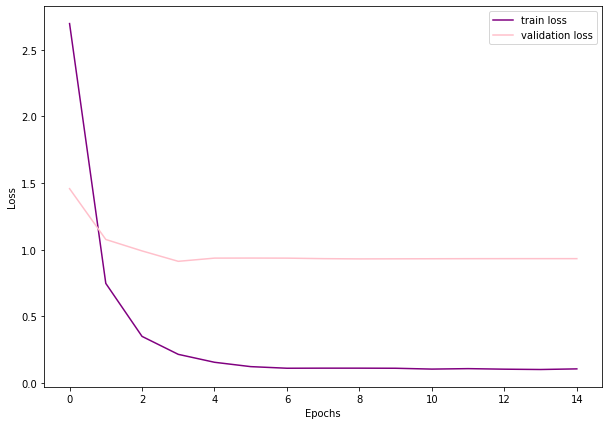

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='purple', label='train loss')
plt.plot(val_loss,color='pink',label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

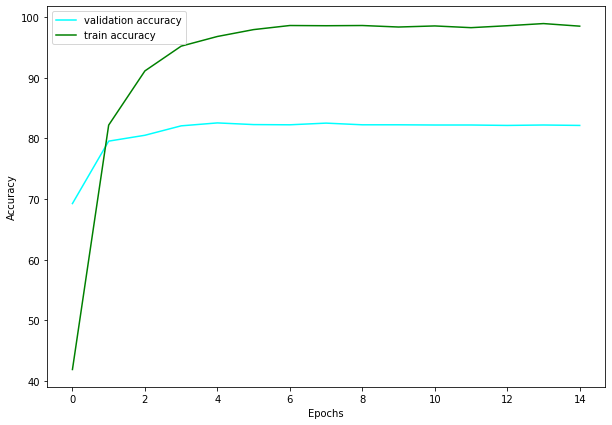

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(val_accuracy, color='cyan', label='validation accuracy')
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Step-Size optimization

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-6  # Regularization, you can keep this at the default

NUM_EPOCHS = 15     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [ ]:
transfer=alexnet(pretrained=True).to(DEVICE)

print(type(transfer))


transfer.classifier[6]=nn.Linear(4096,NUM_CLASSES)

criterion=nn.CrossEntropyLoss()

parameters_to_optimize=transfer.classifier[6].parameters()

optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY,nesterov=True)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

<class 'torchvision.models.alexnet.AlexNet'>


In [ ]:
start = time.time()
train_loss, val_loss, train_accuracy, val_accuracy = fit(transfer)

end = time.time()

print((end-start)/60, 'minutes')

Starting epoch 1/15, LR = [0.01]
Step 0, Loss 4.867848873138428
Step 10, Loss 1.489439606666565
Validating



Validation Accuracy: 68.49930843706777

Starting epoch 2/15, LR = [0.01]
Step 20, Loss 0.6157451868057251
Validating



Validation Accuracy: 79.84094052558783

Starting epoch 3/15, LR = [0.01]
Step 30, Loss 0.36791107058525085
Validating



Validation Accuracy: 81.29322268326418

Starting epoch 4/15, LR = [0.01]
Step 40, Loss 0.1818903237581253
Validating



Validation Accuracy: 81.91562932226833

Starting epoch 5/15, LR = [0.01]
Step 50, Loss 0.13738730549812317
Validating



Validation Accuracy: 82.2268326417704

Starting epoch 6/15, LR = [0.01]
Step 60, Loss 0.10766571015119553
Validating



Validation Accuracy: 82.43430152143846

Starting epoch 7/15, LR = [0.01]
Step 70, Loss 0.09341410547494888
Validating



Validation Accuracy: 82.01936376210236

Starting epoch 8/15, LR = [0.01]
Step 80, Loss 0.0974990576505661
Validating



Validation Accuracy: 82.36514522821577

Starting epoch 9/15, LR = [0.01]
Step 90, Loss 0.07684674859046936
Validating



Validation Accuracy: 82.2268326417704

Starting epoch 10/15, LR = [0.01]
Step 100, Loss 0.06504346430301666
Validating



Validation Accuracy: 82.53803596127247

Starting epoch 11/15, LR = [0.001]
Step 110, Loss 0.08205726742744446
Step 120, Loss 0.06735396385192871
Validating



Validation Accuracy: 82.50345781466113

Starting epoch 12/15, LR = [0.001]
Step 130, Loss 0.05705462023615837
Validating



Validation Accuracy: 82.36514522821577

Starting epoch 13/15, LR = [0.001]
Step 140, Loss 0.07513664662837982
Validating



Validation Accuracy: 82.4688796680498

Starting epoch 14/15, LR = [0.001]
Step 150, Loss 0.057901084423065186
Validating



Validation Accuracy: 82.60719225449516

Starting epoch 15/15, LR = [0.001]
Step 160, Loss 0.057000041007995605
Validating



Validation Accuracy: 82.57261410788382

5.278413323561351 minutes


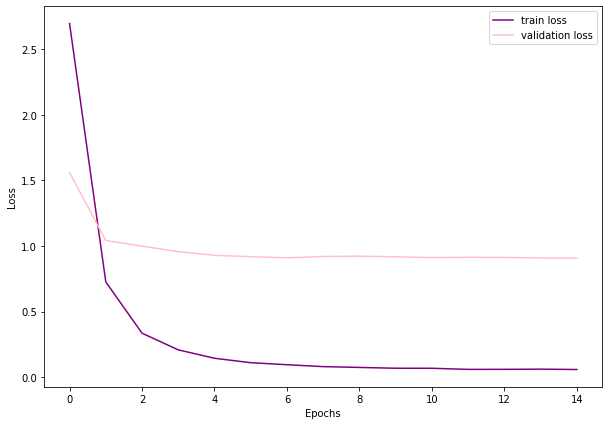

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='purple', label='train loss')
plt.plot(val_loss,color='pink',label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

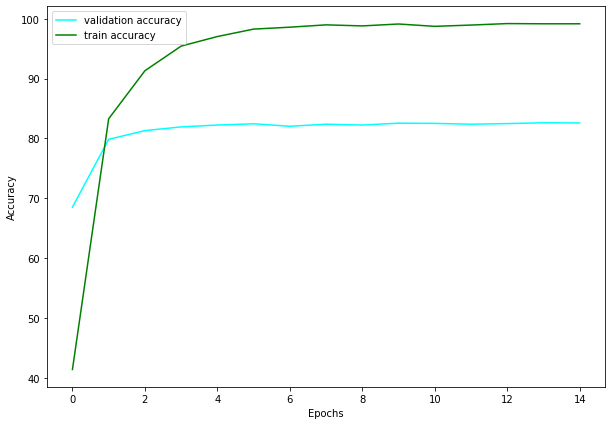

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(val_accuracy, color='cyan', label='validation accuracy')
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Decay rate (Gamma) optimization

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-6  # Regularization, you can keep this at the default

NUM_EPOCHS = 15     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.2          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [ ]:
transfer=alexnet(pretrained=True).to(DEVICE)

print(type(transfer))


transfer.classifier[6]=nn.Linear(4096,NUM_CLASSES)

criterion=nn.CrossEntropyLoss()

parameters_to_optimize=transfer.classifier[6].parameters()

optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY,nesterov=True)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

<class 'torchvision.models.alexnet.AlexNet'>


In [ ]:
start = time.time()
train_loss, val_loss, train_accuracy, val_accuracy = fit(transfer)

end = time.time()

print((end-start)/60, 'minutes')

Starting epoch 1/15, LR = [0.01]
Step 0, Loss 4.874606132507324
Step 10, Loss 1.6138032674789429
Validating



Validation Accuracy: 68.015214384509

Starting epoch 2/15, LR = [0.01]
Step 20, Loss 0.5831672549247742
Validating



Validation Accuracy: 79.63347164591978

Starting epoch 3/15, LR = [0.01]
Step 30, Loss 0.30945226550102234
Validating



Validation Accuracy: 81.25864453665284

Starting epoch 4/15, LR = [0.01]
Step 40, Loss 0.202056884765625
Validating



Validation Accuracy: 82.2268326417704

Starting epoch 5/15, LR = [0.01]
Step 50, Loss 0.16073597967624664
Validating



Validation Accuracy: 82.4688796680498

Starting epoch 6/15, LR = [0.01]
Step 60, Loss 0.0928114727139473
Validating



Validation Accuracy: 81.53526970954357

Starting epoch 7/15, LR = [0.01]
Step 70, Loss 0.11224579811096191
Validating



Validation Accuracy: 82.26141078838174

Starting epoch 8/15, LR = [0.01]
Step 80, Loss 0.07770528644323349
Validating



Validation Accuracy: 82.60719225449516

Starting epoch 9/15, LR = [0.01]
Step 90, Loss 0.07023833692073822
Validating



Validation Accuracy: 82.71092669432919

Starting epoch 10/15, LR = [0.01]
Step 100, Loss 0.06866709887981415
Validating



Validation Accuracy: 82.33056708160443

Starting epoch 11/15, LR = [0.002]
Step 110, Loss 0.05685555562376976
Step 120, Loss 0.05543772876262665
Validating



Validation Accuracy: 82.33056708160443

Starting epoch 12/15, LR = [0.002]
Step 130, Loss 0.07192771136760712
Validating



Validation Accuracy: 82.3997233748271

Starting epoch 13/15, LR = [0.002]
Step 140, Loss 0.05684598535299301
Validating



Validation Accuracy: 82.4688796680498

Starting epoch 14/15, LR = [0.002]
Step 150, Loss 0.04476781189441681
Validating



Validation Accuracy: 82.50345781466113

Starting epoch 15/15, LR = [0.002]
Step 160, Loss 0.047075025737285614
Validating



Validation Accuracy: 82.43430152143846

5.214858412742615 minutes


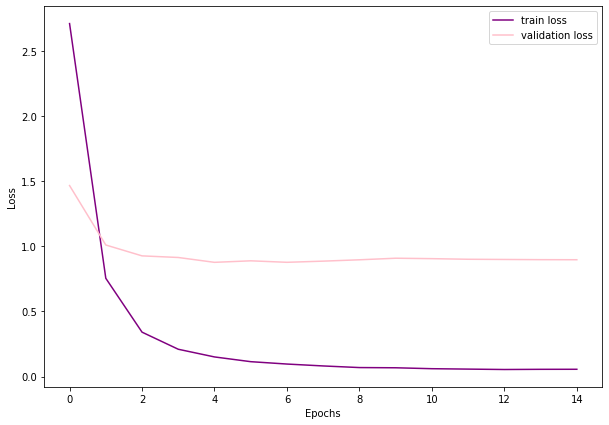

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='purple', label='train loss')
plt.plot(val_loss,color='pink',label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

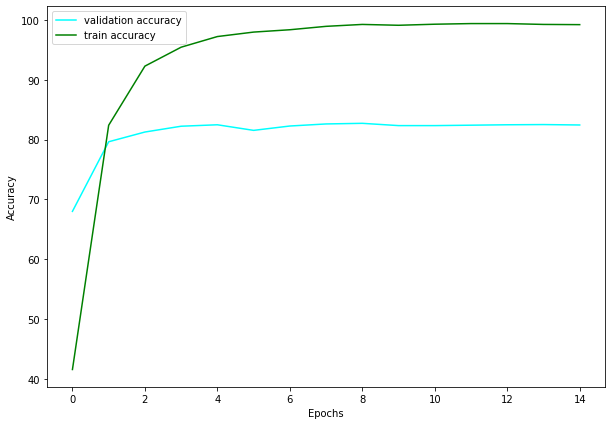

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(val_accuracy, color='cyan', label='validation accuracy')
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-6  # Regularization, you can keep this at the default

NUM_EPOCHS = 15     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.3          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [ ]:
transfer=alexnet(pretrained=True).to(DEVICE)

print(type(transfer))


transfer.classifier[6]=nn.Linear(4096,NUM_CLASSES)

criterion=nn.CrossEntropyLoss()

parameters_to_optimize=transfer.classifier[6].parameters()

optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY,nesterov=True)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

<class 'torchvision.models.alexnet.AlexNet'>


In [ ]:
start = time.time()
train_loss, val_loss, train_accuracy, val_accuracy = fit(transfer)

end = time.time()

print((end-start)/60, 'minutes')

Starting epoch 1/15, LR = [0.01]
Step 0, Loss 4.930400371551514
Step 10, Loss 1.6334248781204224
Validating



Validation Accuracy: 68.91424619640387

Starting epoch 2/15, LR = [0.01]
Step 20, Loss 0.6010161638259888
Validating



Validation Accuracy: 79.35684647302905

Starting epoch 3/15, LR = [0.01]
Step 30, Loss 0.34773245453834534
Validating



Validation Accuracy: 81.91562932226833

Starting epoch 4/15, LR = [0.01]
Step 40, Loss 0.18168582022190094
Validating



Validation Accuracy: 82.33056708160443

Starting epoch 5/15, LR = [0.01]
Step 50, Loss 0.14003385603427887
Validating



Validation Accuracy: 81.74273858921161

Starting epoch 6/15, LR = [0.01]
Step 60, Loss 0.12820197641849518
Validating



Validation Accuracy: 82.36514522821577

Starting epoch 7/15, LR = [0.01]
Step 70, Loss 0.11576882004737854
Validating



Validation Accuracy: 82.0539419087137

Starting epoch 8/15, LR = [0.01]
Step 80, Loss 0.06181834265589714
Validating



Validation Accuracy: 82.6417704011065

Starting epoch 9/15, LR = [0.01]
Step 90, Loss 0.07288473844528198
Validating



Validation Accuracy: 82.4688796680498

Starting epoch 10/15, LR = [0.01]
Step 100, Loss 0.05277136713266373
Validating



Validation Accuracy: 82.57261410788382

Starting epoch 11/15, LR = [0.003]
Step 110, Loss 0.07066549360752106
Step 120, Loss 0.05251573026180267
Validating



Validation Accuracy: 82.36514522821577

Starting epoch 12/15, LR = [0.003]
Step 130, Loss 0.056110136210918427
Validating



Validation Accuracy: 82.60719225449516

Starting epoch 13/15, LR = [0.003]
Step 140, Loss 0.056483957916498184
Validating



Validation Accuracy: 82.33056708160443

Starting epoch 14/15, LR = [0.003]
Step 150, Loss 0.05318397283554077
Validating



Validation Accuracy: 82.36514522821577

Starting epoch 15/15, LR = [0.003]
Step 160, Loss 0.059268951416015625
Validating



Validation Accuracy: 82.19225449515906

5.276266479492188 minutes


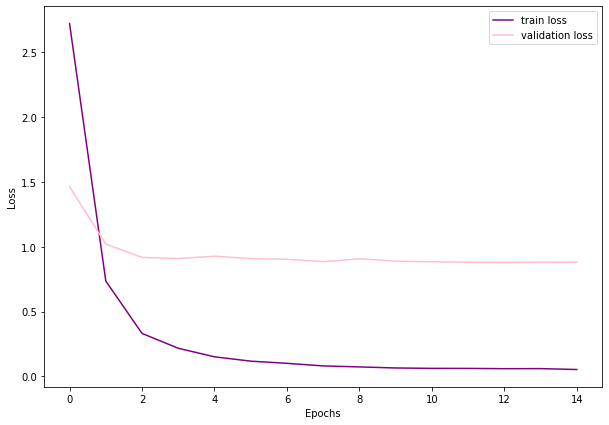

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='purple', label='train loss')
plt.plot(val_loss,color='pink',label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

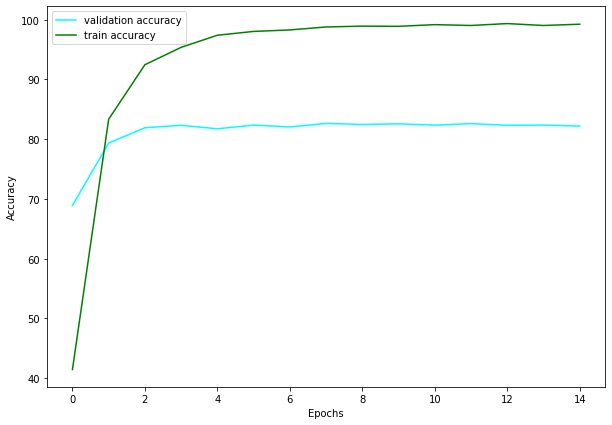

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(val_accuracy, color='cyan', label='validation accuracy')
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Best model on the test set

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-6  # Regularization, you can keep this at the default

NUM_EPOCHS = 15     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.2          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [ ]:
transfer=alexnet(pretrained=True).to(DEVICE)

print(type(transfer))


transfer.classifier[6]=nn.Linear(4096,NUM_CLASSES)

criterion=nn.CrossEntropyLoss()

parameters_to_optimize=transfer.classifier[6].parameters()

optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY,nesterov=True)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

<class 'torchvision.models.alexnet.AlexNet'>


In [ ]:
start = time.time()
train_loss, val_loss, train_accuracy, val_accuracy = fit(transfer)

end = time.time()

print((end-start)/60, 'minutes')

Starting epoch 1/15, LR = [0.01]
Step 0, Loss 4.944654941558838
Step 10, Loss 1.3371621370315552
Validating



Validation Accuracy: 70.95435684647303

Starting epoch 2/15, LR = [0.01]
Step 20, Loss 0.5784466862678528
Validating



Validation Accuracy: 79.5643153526971

Starting epoch 3/15, LR = [0.01]
Step 30, Loss 0.3310752511024475
Validating



Validation Accuracy: 81.32780082987551

Starting epoch 4/15, LR = [0.01]
Step 40, Loss 0.17642635107040405
Validating



Validation Accuracy: 81.67358229598894

Starting epoch 5/15, LR = [0.01]
Step 50, Loss 0.12103713303804398
Validating



Validation Accuracy: 82.01936376210236

Starting epoch 6/15, LR = [0.01]
Step 60, Loss 0.12929901480674744
Validating



Validation Accuracy: 81.984785615491

Starting epoch 7/15, LR = [0.01]
Step 70, Loss 0.07955746352672577
Validating



Validation Accuracy: 82.29598893499309

Starting epoch 8/15, LR = [0.01]
Step 80, Loss 0.07405950129032135
Validating



Validation Accuracy: 81.84647302904564

Starting epoch 9/15, LR = [0.01]
Step 90, Loss 0.08575104176998138
Validating



Validation Accuracy: 82.36514522821577

Starting epoch 10/15, LR = [0.01]
Step 100, Loss 0.07369492202997208
Validating



Validation Accuracy: 82.43430152143846

Starting epoch 11/15, LR = [0.002]
Step 110, Loss 0.04122687876224518
Step 120, Loss 0.07111439108848572
Validating



Validation Accuracy: 82.15767634854772

Starting epoch 12/15, LR = [0.002]
Step 130, Loss 0.0674365907907486
Validating



Validation Accuracy: 82.29598893499309

Starting epoch 13/15, LR = [0.002]
Step 140, Loss 0.0697469711303711
Validating



Validation Accuracy: 82.36514522821577

Starting epoch 14/15, LR = [0.002]
Step 150, Loss 0.04732472822070122
Validating



Validation Accuracy: 82.33056708160443

Starting epoch 15/15, LR = [0.002]
Step 160, Loss 0.04991210252046585
Validating



Validation Accuracy: 82.3997233748271

5.270846394697825 minutes


In [ ]:
result = test(transfer)

print('Accuracy of the network on test images: %0.3f %%' % (100 * result))

Testing



Accuracy of the network on test images: 83.305 %


# FREEZING LAYERS

## Transfer learning with only fully connected layers

In [ ]:
transfer=alexnet(pretrained=True).to(DEVICE)


#layers to freeze

for parameter in transfer.features.parameters():
  parameter.requires_grad=False


#transfer2.classifier[6]=nn.Linear(4096,NUM_CLASSES)

transfer.classifier[6] = nn.Linear(4096,NUM_CLASSES)

criterion=nn.CrossEntropyLoss()

parameters_to_optimize=transfer.classifier.parameters()

optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY,nesterov=True)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
print(transfer)

<class 'torchvision.models.alexnet.AlexNet'>
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_f

In [ ]:
start = time.time()
train_loss, val_loss, train_accuracy, val_accuracy = fit(transfer)

end = time.time()

print((end-start)/60, 'minutes')

Starting epoch 1/15, LR = [0.01]
Step 0, Loss 5.101272106170654
Step 10, Loss 1.4764248132705688
Validating



Validation Accuracy: 70.29737206085754

Starting epoch 2/15, LR = [0.01]
Step 20, Loss 0.4419995844364166
Validating



Validation Accuracy: 80.11756569847856

Starting epoch 3/15, LR = [0.01]
Step 30, Loss 0.20304745435714722
Validating



Validation Accuracy: 81.50069156293223

Starting epoch 4/15, LR = [0.01]
Step 40, Loss 0.11239022016525269
Validating



Validation Accuracy: 82.36514522821577

Starting epoch 5/15, LR = [0.01]
Step 50, Loss 0.08222304284572601
Validating



Validation Accuracy: 82.67634854771784

Starting epoch 6/15, LR = [0.01]
Step 60, Loss 0.06199879199266434
Validating



Validation Accuracy: 82.3997233748271

Starting epoch 7/15, LR = [0.01]
Step 70, Loss 0.0270673967897892
Validating



Validation Accuracy: 82.4688796680498

Starting epoch 8/15, LR = [0.01]
Step 80, Loss 0.022806433960795403
Validating



Validation Accuracy: 82.8146611341632

Starting epoch 9/15, LR = [0.01]
Step 90, Loss 0.0214899480342865
Validating



Validation Accuracy: 83.0567081604426

Starting epoch 10/15, LR = [0.01]
Step 100, Loss 0.03094606101512909
Validating



Validation Accuracy: 82.98755186721992

Starting epoch 11/15, LR = [0.002]
Step 110, Loss 0.030921803787350655
Step 120, Loss 0.021962251514196396
Validating



Validation Accuracy: 83.02213001383126

Starting epoch 12/15, LR = [0.002]
Step 130, Loss 0.018345337361097336
Validating



Validation Accuracy: 83.09128630705395

Starting epoch 13/15, LR = [0.002]
Step 140, Loss 0.014998242259025574
Validating



Validation Accuracy: 83.0567081604426

Starting epoch 14/15, LR = [0.002]
Step 150, Loss 0.023962680250406265
Validating



Validation Accuracy: 83.19502074688796

Starting epoch 15/15, LR = [0.002]
Step 160, Loss 0.02551095560193062
Validating



Validation Accuracy: 83.22959889349931

6.57539168993632 minutes


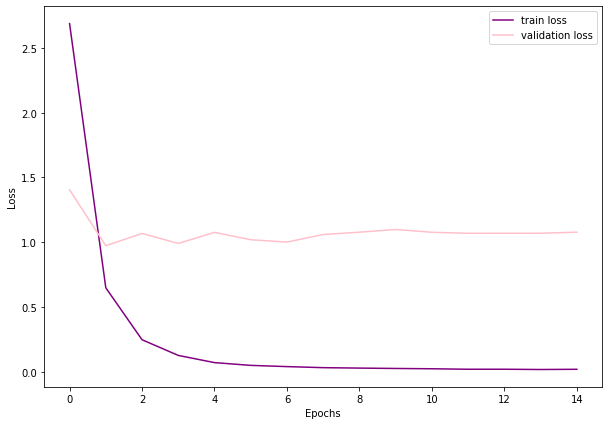

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='purple', label='train loss')
plt.plot(val_loss,color='pink',label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

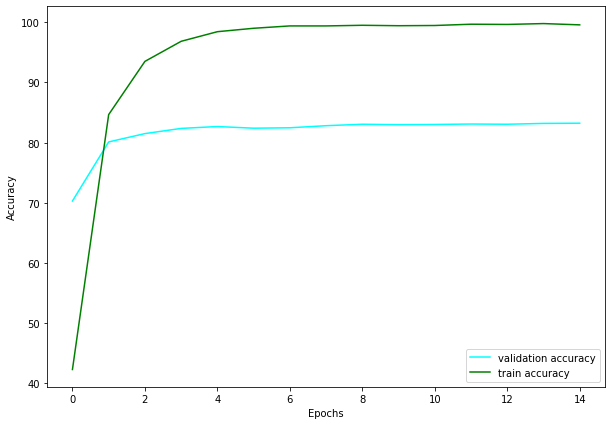

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(val_accuracy, color='cyan', label='validation accuracy')
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
result = test(transfer)

print('Accuracy of the network on test images: %0.3f %%' % (100 * result))

Testing



Accuracy of the network on test images: 84.100 %


## Transfer learning with only convolutional layers

In [ ]:
transfer=alexnet(pretrained=True).to(DEVICE)

print(type(transfer))

#layers to freeze

for parameter in transfer.classifier.parameters():
  parameter.requires_grad=False


#transfer2.classifier[6]=nn.Linear(4096,NUM_CLASSES)

transfer.classifier[6] = nn.Linear(4096,NUM_CLASSES)

criterion=nn.CrossEntropyLoss()

parameters=list(transfer.features.parameters())+ list(transfer.classifier[6].parameters())

parameters_to_optimize=(p for p in parameters)

optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY,nesterov=True)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

print(transfer)

<class 'torchvision.models.alexnet.AlexNet'>
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_f

In [ ]:
start = time.time()
train_loss, val_loss, train_accuracy, val_accuracy = fit(transfer)

end = time.time()

print((end-start)/60, 'minutes')

Starting epoch 1/15, LR = [0.01]
Step 0, Loss 4.894199371337891
Step 10, Loss 1.5081820487976074
Validating



Validation Accuracy: 69.32918395573998

Starting epoch 2/15, LR = [0.01]
Step 20, Loss 0.5325585603713989
Validating



Validation Accuracy: 79.01106500691563

Starting epoch 3/15, LR = [0.01]
Step 30, Loss 0.16934482753276825
Validating



Validation Accuracy: 81.70816044260027

Starting epoch 4/15, LR = [0.01]
Step 40, Loss 0.12993210554122925
Validating



Validation Accuracy: 81.984785615491

Starting epoch 5/15, LR = [0.01]
Step 50, Loss 0.05925825610756874
Validating



Validation Accuracy: 82.33056708160443

Starting epoch 6/15, LR = [0.01]
Step 60, Loss 0.028444800525903702
Validating



Validation Accuracy: 83.0567081604426

Starting epoch 7/15, LR = [0.01]
Step 70, Loss 0.052990689873695374
Validating



Validation Accuracy: 82.12309820193637

Starting epoch 8/15, LR = [0.01]
Step 80, Loss 0.07349991798400879
Validating



Validation Accuracy: 82.29598893499309

Starting epoch 9/15, LR = [0.01]
Step 90, Loss 0.02184605970978737
Validating



Validation Accuracy: 82.8146611341632

Starting epoch 10/15, LR = [0.01]
Step 100, Loss 0.015499524772167206
Validating



Validation Accuracy: 82.33056708160443

Starting epoch 11/15, LR = [0.002]
Step 110, Loss 0.01402469351887703
Step 120, Loss 0.007729239761829376
Validating



Validation Accuracy: 83.12586445366529

Starting epoch 12/15, LR = [0.002]
Step 130, Loss 0.005017131567001343
Validating



Validation Accuracy: 83.60995850622406

Starting epoch 13/15, LR = [0.002]
Step 140, Loss 0.0077812522649765015
Validating



Validation Accuracy: 83.71369294605809

Starting epoch 14/15, LR = [0.002]
Step 150, Loss 0.004157882183790207
Validating



Validation Accuracy: 84.05947441217151

Starting epoch 15/15, LR = [0.002]
Step 160, Loss 0.004459850490093231
Validating



Validation Accuracy: 83.95573997233748

6.8534231901168825 minutes


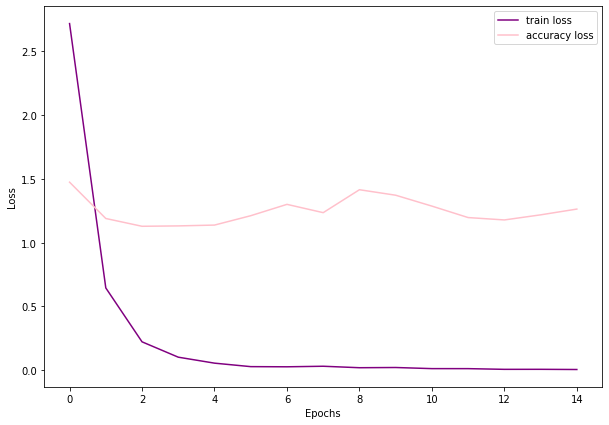

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='purple', label='train loss')
plt.plot(val_loss,color='pink',label='accuracy loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

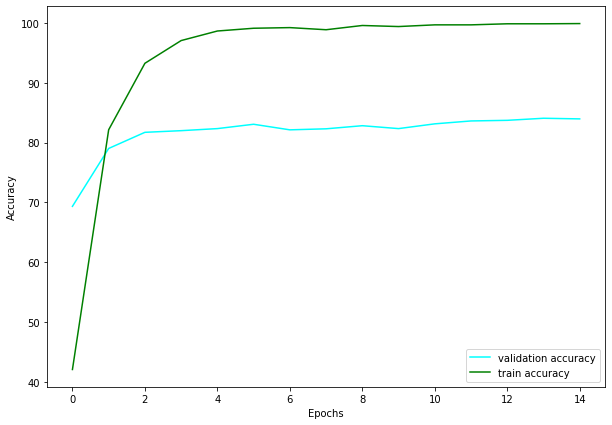

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(val_accuracy, color='cyan', label='validation accuracy')
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
result = test(transfer)

print('Accuracy of the network on test images: %0.3f %%' % (100 * result))

Testing



Accuracy of the network on test images: 84.653 %


# DATA AUGMENTATION

## Transoformation 1

In [ ]:

# Define transforms for training phase
transform1 = transforms.Compose([transforms.Resize(256),      
                                      transforms.RandomCrop(224),  
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomVerticalFlip(p=0.2),
                                      transforms.ColorJitter(2,4,5,0.2),                             
                                                                   
                                      transforms.ToTensor(), 
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),                     
])
# Define transforms for the evaluation phase
eval_transform_transfer = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])                                   
])

In [ ]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/davibuss/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'
from Caltech101.caltech_dataset import Caltech


# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=transform1)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform_transfer)
print(type(train_dataset))
 # split to train val

train_len = int(train_dataset.__len__() * 0.5)
val_len = int(train_dataset.__len__() * 0.5)
train_indexes = np.arange(train_dataset.__len__())
print(train_indexes)
train_labels = np.empty(train_dataset.__len__(), dtype=int)


for index in train_indexes:
  train_labels[index] = train_dataset.__getitem__(index)[1]
  
print(train_labels)  

train_indexes, val_indexes, _, _ = train_test_split(train_indexes, train_labels, test_size=0.5, random_state=42, stratify=train_labels)


"""
validation_split = 0.5
dataset_size = len(train_dataset)
#print(dataset_size)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if 1 :
    np.random.seed(1337)
    np.random.shuffle(indices)
train_indexes, val_indexes = indices[split:], indices[:split]

print(type(train_indexes))
#train_indexes = SubsetRandomSampler(train_indices)
#val_indexes = SubsetRandomSampler(valid_indices)
#train_indexes, val_indexes = 
#print(type(train_indexes))
#print(train_indexes)
"""

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

<class 'Caltech101.caltech_dataset.Caltech'>
[   0    1    2 ... 5781 5782 5783]
[  0   0   0 ... 100 100 100]
Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(type(train_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-6  # Regularization, you can keep this at the default

NUM_EPOCHS = 15     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.2          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [ ]:
transfer=alexnet(pretrained=True).to(DEVICE)

print(type(transfer))


transfer.classifier[6]=nn.Linear(4096,NUM_CLASSES)

criterion=nn.CrossEntropyLoss()

parameters_to_optimize=transfer.parameters()

optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY,nesterov=True)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

<class 'torchvision.models.alexnet.AlexNet'>


In [ ]:
start = time.time()
train_loss, val_loss, train_accuracy, val_accuracy = fit(transfer)

end = time.time()

print((end-start)/60, 'minutes')

Starting epoch 1/15, LR = [0.01]
Step 0, Loss 4.922883033752441
Step 10, Loss 2.8293404579162598
Validating



Validation Accuracy: 41.147994467496545

Starting epoch 2/15, LR = [0.01]
Step 20, Loss 2.5305795669555664
Validating



Validation Accuracy: 51.93637621023513

Starting epoch 3/15, LR = [0.01]
Step 30, Loss 1.5640192031860352
Validating



Validation Accuracy: 54.25311203319502

Starting epoch 4/15, LR = [0.01]
Step 40, Loss 1.5362718105316162
Validating



Validation Accuracy: 60.511756569847854

Starting epoch 5/15, LR = [0.01]
Step 50, Loss 1.4243525266647339
Validating



Validation Accuracy: 61.09958506224066

Starting epoch 6/15, LR = [0.01]
Step 60, Loss 1.3327915668487549
Validating



Validation Accuracy: 61.964038727524205

Starting epoch 7/15, LR = [0.01]
Step 70, Loss 1.1370989084243774
Validating



Validation Accuracy: 63.13969571230982

Starting epoch 8/15, LR = [0.01]
Step 80, Loss 1.0333518981933594
Validating



Validation Accuracy: 64.17704011065007

Starting epoch 9/15, LR = [0.01]
Step 90, Loss 1.03158700466156
Validating



Validation Accuracy: 62.69017980636238

Starting epoch 10/15, LR = [0.01]
Step 100, Loss 1.163029670715332
Validating



Validation Accuracy: 64.00414937759336

Starting epoch 11/15, LR = [0.002]
Step 110, Loss 1.0276079177856445
Step 120, Loss 0.8637445569038391
Validating



Validation Accuracy: 66.32088520055325

Starting epoch 12/15, LR = [0.002]
Step 130, Loss 0.5854987502098083
Validating



Validation Accuracy: 68.70677731673582

Starting epoch 13/15, LR = [0.002]
Step 140, Loss 0.689445972442627
Validating



Validation Accuracy: 68.87966804979253

Starting epoch 14/15, LR = [0.002]
Step 150, Loss 0.753500759601593
Validating



Validation Accuracy: 69.64038727524205

Starting epoch 15/15, LR = [0.002]
Step 160, Loss 0.6295227408409119
Validating



Validation Accuracy: 69.91701244813278

12.793884019056955 minutes


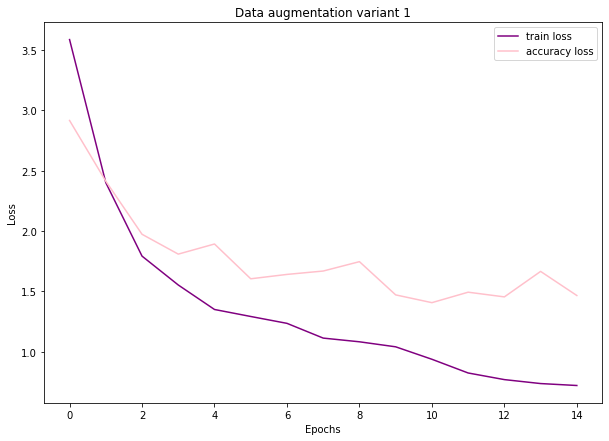

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Data augmentation variant 1")
plt.plot(train_loss, color='purple', label='train loss')
plt.plot(val_loss,color='pink',label='accuracy loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

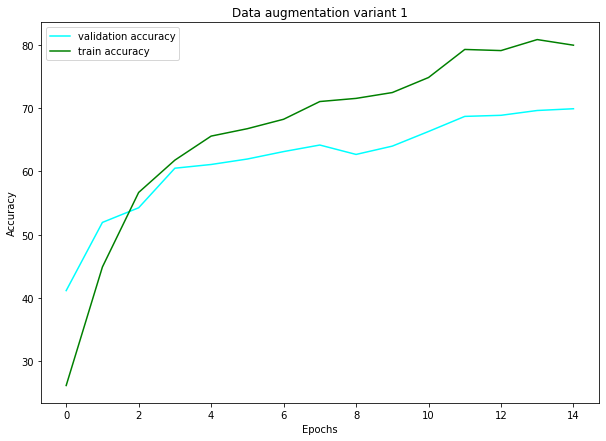

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Data augmentation variant 1")
plt.plot(val_accuracy, color='cyan', label='validation accuracy')
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
result = test(transfer)

print('Accuracy of the network on test images: %0.3f %%' % (100 * result))

Testing



Accuracy of the network on test images: 82.026 %


## Transformation 2

In [ ]:
# define pytorch transforms

transform2 = transforms.Compose([transforms.Resize(256),      
                                      transforms.RandomCrop(224),  
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomVerticalFlip(p=0.2),
                                      transforms.Grayscale(3),                             
                                                                   
                                      transforms.ToTensor(), 
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),                     
])

In [ ]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/davibuss/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'
from Caltech101.caltech_dataset import Caltech


# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=transform2)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform_transfer)
print(type(train_dataset))
 # split to train val

train_len = int(train_dataset.__len__() * 0.5)
val_len = int(train_dataset.__len__() * 0.5)
train_indexes = np.arange(train_dataset.__len__())
print(train_indexes)
train_labels = np.empty(train_dataset.__len__(), dtype=int)


for index in train_indexes:
  train_labels[index] = train_dataset.__getitem__(index)[1]
  
print(train_labels)  

train_indexes, val_indexes, _, _ = train_test_split(train_indexes, train_labels, test_size=0.5, random_state=42, stratify=train_labels)


"""
validation_split = 0.5
dataset_size = len(train_dataset)
#print(dataset_size)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if 1 :
    np.random.seed(1337)
    np.random.shuffle(indices)
train_indexes, val_indexes = indices[split:], indices[:split]

print(type(train_indexes))
#train_indexes = SubsetRandomSampler(train_indices)
#val_indexes = SubsetRandomSampler(valid_indices)
#train_indexes, val_indexes = 
#print(type(train_indexes))
#print(train_indexes)
"""

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

<class 'Caltech101.caltech_dataset.Caltech'>
[   0    1    2 ... 5781 5782 5783]
[  0   0   0 ... 100 100 100]
Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(type(train_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
start = time.time()
train_loss, val_loss, train_accuracy, val_accuracy = fit(transfer)

end = time.time()

print((end-start)/60, 'minutes')

Starting epoch 1/15, LR = [0.01]
Step 0, Loss 4.895662784576416
Step 10, Loss 1.967391848564148
Validating



Validation Accuracy: 59.68188105117566

Starting epoch 2/15, LR = [0.01]
Step 20, Loss 1.0687915086746216
Validating



Validation Accuracy: 66.59751037344398

Starting epoch 3/15, LR = [0.01]
Step 30, Loss 0.7649048566818237
Validating



Validation Accuracy: 72.75242047026279

Starting epoch 4/15, LR = [0.01]
Step 40, Loss 0.561473548412323
Validating



Validation Accuracy: 74.48132780082987

Starting epoch 5/15, LR = [0.01]
Step 50, Loss 0.24793918430805206
Validating



Validation Accuracy: 74.44674965421854

Starting epoch 6/15, LR = [0.01]
Step 60, Loss 0.5119827389717102
Validating



Validation Accuracy: 75.03457814661134

Starting epoch 7/15, LR = [0.01]
Step 70, Loss 0.3179837465286255
Validating



Validation Accuracy: 76.86721991701245

Starting epoch 8/15, LR = [0.01]
Step 80, Loss 0.3031783103942871
Validating



Validation Accuracy: 73.72060857538035

Starting epoch 9/15, LR = [0.01]
Step 90, Loss 0.16574685275554657
Validating



Validation Accuracy: 75.4149377593361

Starting epoch 10/15, LR = [0.01]
Step 100, Loss 0.22339347004890442
Validating



Validation Accuracy: 75.34578146611342

Starting epoch 11/15, LR = [0.002]
Step 110, Loss 0.2204049527645111
Step 120, Loss 0.09739643335342407
Validating



Validation Accuracy: 77.52420470262794

Starting epoch 12/15, LR = [0.002]
Step 130, Loss 0.126712828874588
Validating



Validation Accuracy: 78.1466113416321

Starting epoch 13/15, LR = [0.002]
Step 140, Loss 0.12243042886257172
Validating



Validation Accuracy: 77.69709543568464

Starting epoch 14/15, LR = [0.002]
Step 150, Loss 0.1094275414943695
Validating



Validation Accuracy: 78.04287690179807

Starting epoch 15/15, LR = [0.002]
Step 160, Loss 0.08946819603443146
Validating



Validation Accuracy: 77.38589211618257

7.555080290635427 minutes


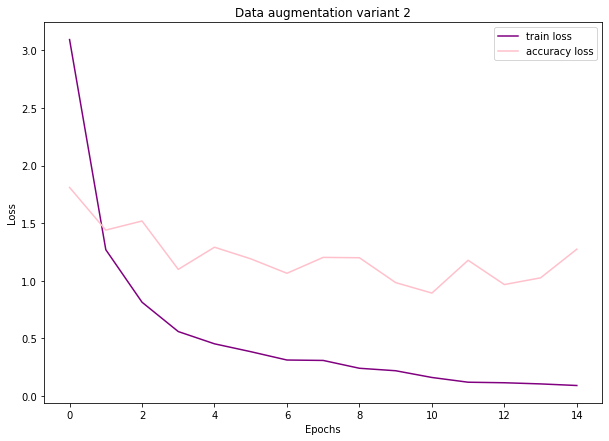

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Data augmentation variant 2")
plt.plot(train_loss, color='purple', label='train loss')
plt.plot(val_loss,color='pink',label='accuracy loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

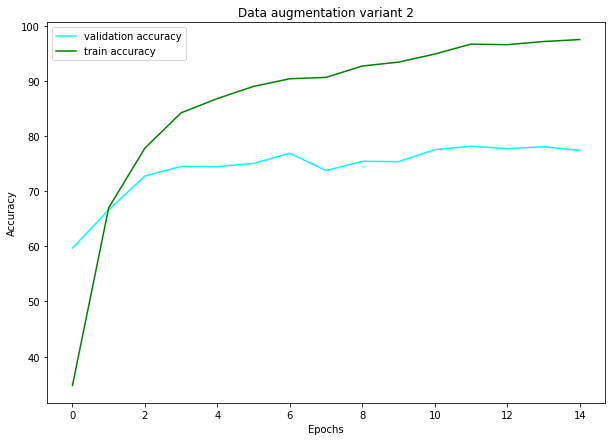

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Data augmentation variant 2")
plt.plot(val_accuracy, color='cyan', label='validation accuracy')
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
result = test(transfer)

print('Accuracy of the network on test images: %0.3f %%' % (100 * result))

Testing



Accuracy of the network on test images: 81.749 %


## Transformation 3

In [ ]:
# define pytorch transforms

transform3 = transforms.Compose([transforms.Resize(256),      
                                      transforms.RandomCrop(224),  
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomVerticalFlip(p=0.2),
                                                                  
                                                                   
                                      transforms.ToTensor(), 
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),                     
])

In [ ]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/davibuss/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'
from Caltech101.caltech_dataset import Caltech


# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=transform3)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform_transfer)
print(type(train_dataset))
 # split to train val

train_len = int(train_dataset.__len__() * 0.5)
val_len = int(train_dataset.__len__() * 0.5)
train_indexes = np.arange(train_dataset.__len__())
print(train_indexes)
train_labels = np.empty(train_dataset.__len__(), dtype=int)


for index in train_indexes:
  train_labels[index] = train_dataset.__getitem__(index)[1]
  
print(train_labels)  

train_indexes, val_indexes, _, _ = train_test_split(train_indexes, train_labels, test_size=0.5, random_state=42, stratify=train_labels)


"""
validation_split = 0.5
dataset_size = len(train_dataset)
#print(dataset_size)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if 1 :
    np.random.seed(1337)
    np.random.shuffle(indices)
train_indexes, val_indexes = indices[split:], indices[:split]

print(type(train_indexes))
#train_indexes = SubsetRandomSampler(train_indices)
#val_indexes = SubsetRandomSampler(valid_indices)
#train_indexes, val_indexes = 
#print(type(train_indexes))
#print(train_indexes)
"""

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

<class 'Caltech101.caltech_dataset.Caltech'>
[   0    1    2 ... 5781 5782 5783]
[  0   0   0 ... 100 100 100]
Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(type(train_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
start = time.time()
train_loss, val_loss, train_accuracy, val_accuracy = fit(transfer)

end = time.time()

print((end-start)/60, 'minutes')

Starting epoch 1/15, LR = [0.01]
Step 0, Loss 4.7576584815979
Step 10, Loss 1.7411648035049438
Validating



Validation Accuracy: 65.45643153526972

Starting epoch 2/15, LR = [0.01]
Step 20, Loss 0.6420522928237915
Validating



Validation Accuracy: 73.54771784232365

Starting epoch 3/15, LR = [0.01]
Step 30, Loss 0.37678033113479614
Validating



Validation Accuracy: 75.79529737206086

Starting epoch 4/15, LR = [0.01]
Step 40, Loss 0.3011947572231293
Validating



Validation Accuracy: 77.80082987551867

Starting epoch 5/15, LR = [0.01]
Step 50, Loss 0.31963521242141724
Validating



Validation Accuracy: 77.38589211618257

Starting epoch 6/15, LR = [0.01]
Step 60, Loss 0.24902178347110748
Validating



Validation Accuracy: 76.17565698478562

Starting epoch 7/15, LR = [0.01]
Step 70, Loss 0.14878113567829132
Validating



Validation Accuracy: 78.97648686030429

Starting epoch 8/15, LR = [0.01]
Step 80, Loss 0.09659741818904877
Validating



Validation Accuracy: 76.52143845089903

Starting epoch 9/15, LR = [0.01]
Step 90, Loss 0.16643895208835602
Validating



Validation Accuracy: 77.42047026279391

Starting epoch 10/15, LR = [0.01]
Step 100, Loss 0.19657011330127716
Validating



Validation Accuracy: 78.59612724757953

Starting epoch 11/15, LR = [0.002]
Step 110, Loss 0.10840072482824326
Step 120, Loss 0.08082294464111328
Validating



Validation Accuracy: 79.77178423236515

Starting epoch 12/15, LR = [0.002]
Step 130, Loss 0.025599710643291473
Validating



Validation Accuracy: 79.52973720608576

Starting epoch 13/15, LR = [0.002]
Step 140, Loss 0.10383778810501099
Validating



Validation Accuracy: 79.04564315352697

Starting epoch 14/15, LR = [0.002]
Step 150, Loss 0.06783220171928406
Validating



Validation Accuracy: 79.52973720608576

Starting epoch 15/15, LR = [0.002]
Step 160, Loss 0.08346420526504517
Validating



Validation Accuracy: 79.91009681881052

7.339753758907318 minutes


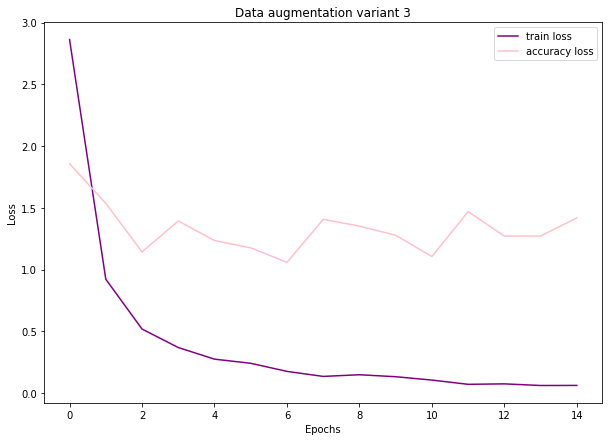

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Data augmentation variant 3")
plt.plot(train_loss, color='purple', label='train loss')
plt.plot(val_loss,color='pink',label='accuracy loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

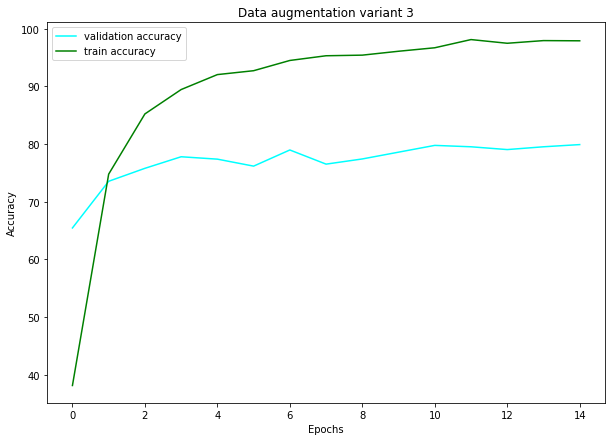

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Data augmentation variant 3")
plt.plot(val_accuracy, color='cyan', label='validation accuracy')
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
result = test(transfer)

print('Accuracy of the network on test images: %0.3f %%' % (100 * result))

Testing



Accuracy of the network on test images: 83.408 %


# OTHER NETWORKS

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 64     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-6  # Regularization, you can keep this at the default

NUM_EPOCHS = 15     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.2          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [ ]:
# Define transforms for training phase
train_transform_transfer = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225]) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform_transfer = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])                                   
])

In [ ]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/davibuss/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'
from Caltech101.caltech_dataset import Caltech


# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform_transfer)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform_transfer)
print(type(train_dataset))
 # split to train val

train_len = int(train_dataset.__len__() * 0.5)
val_len = int(train_dataset.__len__() * 0.5)
train_indexes = np.arange(train_dataset.__len__())
print(train_indexes)
train_labels = np.empty(train_dataset.__len__(), dtype=int)


for index in train_indexes:
  train_labels[index] = train_dataset.__getitem__(index)[1]
print(train_labels)  

train_indexes, val_indexes, _, _ = train_test_split(train_indexes, train_labels, test_size=0.5, random_state=42, stratify=train_labels)


"""
validation_split = 0.5
dataset_size = len(train_dataset)
#print(dataset_size)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if 1 :
    np.random.seed(1337)
    np.random.shuffle(indices)
train_indexes, val_indexes = indices[split:], indices[:split]

print(type(train_indexes))
#train_indexes = SubsetRandomSampler(train_indices)
#val_indexes = SubsetRandomSampler(valid_indices)
#train_indexes, val_indexes = 
#print(type(train_indexes))
#print(train_indexes)
"""

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

<class 'Caltech101.caltech_dataset.Caltech'>
[   0    1    2 ... 5781 5782 5783]
[  0   0   0 ... 100 100 100]
Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(type(train_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>


## Resnet 34

In [ ]:
from torchvision.models import resnet34

In [ ]:
transfer=resnet34(pretrained=True).to(DEVICE)

print(type(transfer))
print(transfer)

#transfer.classifier[6]=nn.Linear(4096,NUM_CLASSES)

criterion=nn.CrossEntropyLoss()

parameters_to_optimize=transfer.parameters()

optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY,nesterov=True)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth



<class 'torchvision.models.resnet.ResNet'>
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [ ]:
start = time.time()
train_loss, val_loss, train_accuracy, val_accuracy = fit(transfer)

end = time.time()

print((end-start)/60, 'minutes')

Starting epoch 1/15, LR = [0.01]
Step 0, Loss 12.858292579650879
Step 10, Loss 3.965371608734131
Step 20, Loss 2.8415985107421875
Step 30, Loss 2.432647228240967
Step 40, Loss 2.2613558769226074
Validating



Validation Accuracy: 58.78284923928077

Starting epoch 2/15, LR = [0.01]
Step 50, Loss 0.831115186214447
Step 60, Loss 0.8402897715568542
Step 70, Loss 0.661182165145874
Step 80, Loss 0.5566189289093018
Validating



Validation Accuracy: 74.23928077455048

Starting epoch 3/15, LR = [0.01]
Step 90, Loss 0.272847443819046
Step 100, Loss 0.26359763741493225
Step 110, Loss 0.143940269947052
Step 120, Loss 0.11733885109424591
Step 130, Loss 0.1606122851371765
Validating



Validation Accuracy: 81.36237897648687

Starting epoch 4/15, LR = [0.01]
Step 140, Loss 0.01716458797454834
Step 150, Loss 0.03560522198677063
Step 160, Loss 0.028314977884292603
Step 170, Loss 0.012920588254928589
Validating



Validation Accuracy: 85.26970954356847

Starting epoch 5/15, LR = [0.01]
Step 180, Loss 0.017282336950302124
Step 190, Loss 0.0072605907917022705
Step 200, Loss 0.006235569715499878
Step 210, Loss 0.011623114347457886
Step 220, Loss 0.006485491991043091
Validating



Validation Accuracy: 86.03042876901799

Starting epoch 6/15, LR = [0.01]
Step 230, Loss 0.008026912808418274
Step 240, Loss 0.0038767755031585693
Step 250, Loss 0.004791945219039917
Step 260, Loss 0.004826009273529053
Validating



Validation Accuracy: 86.75656984785616

Starting epoch 7/15, LR = [0.01]
Step 270, Loss 0.005748376250267029
Step 280, Loss 0.004748523235321045
Step 290, Loss 0.0024800151586532593
Step 300, Loss 0.002769157290458679
Step 310, Loss 0.003483876585960388
Validating



Validation Accuracy: 87.06777316735823

Starting epoch 8/15, LR = [0.01]
Step 320, Loss 0.0023472607135772705
Step 330, Loss 0.003996163606643677
Step 340, Loss 0.0018739700317382812
Step 350, Loss 0.0020240843296051025
Validating



Validation Accuracy: 87.10235131396958

Starting epoch 9/15, LR = [0.01]
Step 360, Loss 0.004283979535102844
Step 370, Loss 0.0014875084161758423
Step 380, Loss 0.002600148320198059
Step 390, Loss 0.0013827085494995117
Step 400, Loss 0.0016259551048278809
Validating



Validation Accuracy: 87.03319502074689

Starting epoch 10/15, LR = [0.01]
Step 410, Loss 0.0028382688760757446
Step 420, Loss 0.0021557658910751343
Step 430, Loss 0.0024906545877456665
Step 440, Loss 0.0021840184926986694
Validating



Validation Accuracy: 86.75656984785616

Starting epoch 11/15, LR = [0.002]
Step 450, Loss 0.001424536108970642
Step 460, Loss 0.0016281604766845703
Step 470, Loss 0.001600906252861023
Step 480, Loss 0.0018703341484069824
Step 490, Loss 0.0014204084873199463
Validating



Validation Accuracy: 86.92946058091286

Starting epoch 12/15, LR = [0.002]
Step 500, Loss 0.0025561004877090454
Step 510, Loss 0.0010763853788375854
Step 520, Loss 0.002041235566139221
Step 530, Loss 0.001414969563484192
Validating



Validation Accuracy: 86.75656984785616

Starting epoch 13/15, LR = [0.002]
Step 540, Loss 0.0017840862274169922
Step 550, Loss 0.0015577524900436401
Step 560, Loss 0.0010004639625549316
Step 570, Loss 0.001229509711265564
Step 580, Loss 0.002842918038368225
Validating



Validation Accuracy: 86.89488243430152

Starting epoch 14/15, LR = [0.002]
Step 590, Loss 0.0012264251708984375
Step 600, Loss 0.0013640820980072021
Step 610, Loss 0.001516774296760559
Step 620, Loss 0.0020613670349121094
Validating



Validation Accuracy: 86.68741355463347

Starting epoch 15/15, LR = [0.002]
Step 630, Loss 0.0013554096221923828
Step 640, Loss 0.0012893378734588623
Step 650, Loss 0.0015970617532730103
Step 660, Loss 0.0017708241939544678
Step 670, Loss 0.001158401370048523
Validating



Validation Accuracy: 87.10235131396958

11.116596686840058 minutes


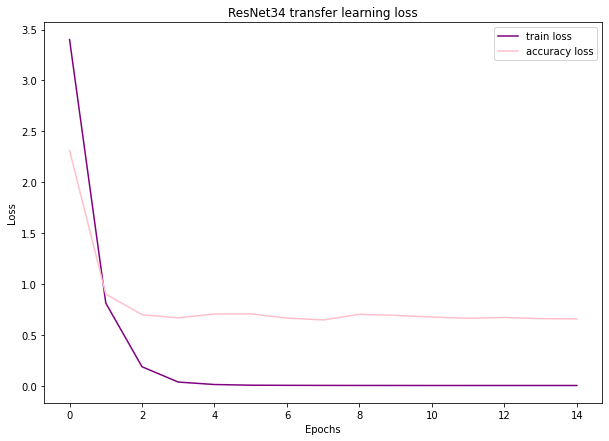

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("ResNet34 transfer learning loss")
plt.plot(train_loss, color='purple', label='train loss')
plt.plot(val_loss,color='pink',label='accuracy loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

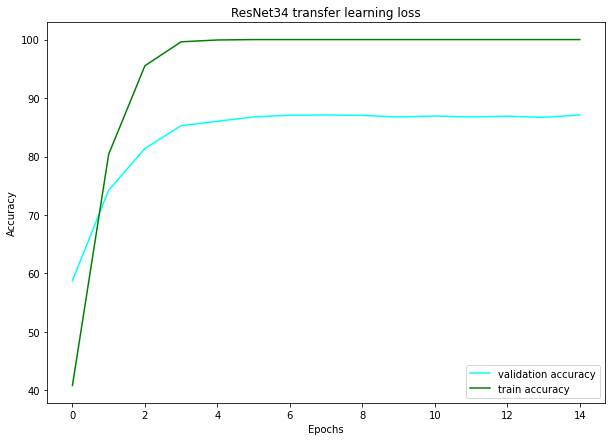

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("ResNet34 transfer learning loss")
plt.plot(val_accuracy, color='cyan', label='validation accuracy')
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
result = test(transfer)

print('Accuracy of the network on test images: %0.3f %%' % (100 * result))

Testing



Accuracy of the network on test images: 88.317 %


## Vgg 16

In [ ]:
from torchvision.models import vgg16

In [ ]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 32     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-3            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-6  # Regularization, you can keep this at the default

NUM_EPOCHS = 15     # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10      # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.2          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [ ]:
# Define transforms for training phase
train_transform_transfer = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225]) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform_transfer = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])                                   
])

In [ ]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/davibuss/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'
from Caltech101.caltech_dataset import Caltech


# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train',  transform=train_transform_transfer)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform_transfer)
print(type(train_dataset))
 # split to train val

train_len = int(train_dataset.__len__() * 0.5)
val_len = int(train_dataset.__len__() * 0.5)
train_indexes = np.arange(train_dataset.__len__())
print(train_indexes)
train_labels = np.empty(train_dataset.__len__(), dtype=int)


for index in train_indexes:
  train_labels[index] = train_dataset.__getitem__(index)[1]
print(train_labels)  

train_indexes, val_indexes, _, _ = train_test_split(train_indexes, train_labels, test_size=0.5, random_state=42, stratify=train_labels)


"""
validation_split = 0.5
dataset_size = len(train_dataset)
#print(dataset_size)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if 1 :
    np.random.seed(1337)
    np.random.shuffle(indices)
train_indexes, val_indexes = indices[split:], indices[:split]

print(type(train_indexes))
#train_indexes = SubsetRandomSampler(train_indices)
#val_indexes = SubsetRandomSampler(valid_indices)
#train_indexes, val_indexes = 
#print(type(train_indexes))
#print(train_indexes)
"""

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

<class 'Caltech101.caltech_dataset.Caltech'>
[   0    1    2 ... 5781 5782 5783]
[  0   0   0 ... 100 100 100]
Train Dataset: 2892
Valid Dataset: 2892
Test Dataset: 2893


In [ ]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(type(train_dataloader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
transfer=vgg16(pretrained=True).to(DEVICE)

print(type(transfer))
print(transfer)

#transfer.classifier[6]=nn.Linear(4096,NUM_CLASSES)

criterion=nn.CrossEntropyLoss()

parameters_to_optimize=transfer.parameters()

optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY,nesterov=True)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



<class 'torchvision.models.vgg.VGG'>
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_s

In [ ]:
start = time.time()
train_loss, val_loss, train_accuracy, val_accuracy = fit(transfer)

end = time.time()

print((end-start)/60, 'minutes')

Starting epoch 1/15, LR = [0.001]
Step 0, Loss 18.042011260986328
Step 10, Loss 5.552877426147461
Step 20, Loss 4.523736953735352
Step 30, Loss 4.290456771850586
Step 40, Loss 4.1854729652404785
Step 50, Loss 3.7971599102020264
Step 60, Loss 3.8288064002990723
Step 70, Loss 3.377631187438965
Step 80, Loss 2.8285040855407715
Validating



Validation Accuracy: 30.221300138312586

Starting epoch 2/15, LR = [0.001]
Step 90, Loss 3.016108989715576
Step 100, Loss 3.043907880783081
Step 110, Loss 4.109658241271973
Step 120, Loss 3.8257007598876953
Step 130, Loss 2.6976470947265625
Step 140, Loss 2.783698081970215
Step 150, Loss 2.455325126647949
Step 160, Loss 2.6013224124908447
Step 170, Loss 3.334224224090576
Validating



Validation Accuracy: 43.25726141078838

Starting epoch 3/15, LR = [0.001]
Step 180, Loss 3.193791389465332
Step 190, Loss 2.8597097396850586
Step 200, Loss 1.8395519256591797
Step 210, Loss 3.0945825576782227
Step 220, Loss 1.9880006313323975
Step 230, Loss 2.7744510173797607
Step 240, Loss 1.9175900220870972
Step 250, Loss 2.03863263130188
Step 260, Loss 2.9030470848083496
Validating



Validation Accuracy: 50.86445366528354

Starting epoch 4/15, LR = [0.001]
Step 270, Loss 1.7430671453475952
Step 280, Loss 1.7615705728530884
Step 290, Loss 2.015547752380371
Step 300, Loss 1.685111165046692
Step 310, Loss 1.6776630878448486
Step 320, Loss 2.361496925354004
Step 330, Loss 1.560687780380249
Step 340, Loss 1.4337036609649658
Step 350, Loss 1.6228065490722656
Validating



Validation Accuracy: 59.923928077455045

Starting epoch 5/15, LR = [0.001]
Step 360, Loss 1.8274699449539185
Step 370, Loss 1.549117088317871
Step 380, Loss 1.1533639430999756
Step 390, Loss 1.4285264015197754
Step 400, Loss 1.0074594020843506
Step 410, Loss 1.2350013256072998
Step 420, Loss 0.994704008102417
Step 430, Loss 1.0854275226593018
Step 440, Loss 1.3334558010101318
Validating



Validation Accuracy: 63.48547717842324

Starting epoch 6/15, LR = [0.001]
Step 450, Loss 1.255197286605835
Step 460, Loss 0.650134801864624
Step 470, Loss 0.838089108467102
Step 480, Loss 0.6748343706130981
Step 490, Loss 0.6402396559715271
Step 500, Loss 0.46623241901397705
Step 510, Loss 0.7392623424530029
Step 520, Loss 0.8705041408538818
Step 530, Loss 0.613631010055542
Validating



Validation Accuracy: 65.04149377593362

Starting epoch 7/15, LR = [0.001]
Step 540, Loss 0.69384765625
Step 550, Loss 0.47474080324172974
Step 560, Loss 0.555135190486908
Step 570, Loss 0.7015141248703003
Step 580, Loss 0.768462598323822
Step 590, Loss 0.4237665832042694
Step 600, Loss 0.4750930070877075
Step 610, Loss 0.6813987493515015
Step 620, Loss 0.4788171947002411
Validating



Validation Accuracy: 70.15905947441217

Starting epoch 8/15, LR = [0.001]
Step 630, Loss 0.2372337281703949
Step 640, Loss 0.6122257113456726
Step 650, Loss 0.203923761844635
Step 660, Loss 0.1898438036441803
Step 670, Loss 0.14794185757637024
Step 680, Loss 0.2657921016216278
Step 690, Loss 0.14340269565582275
Step 700, Loss 0.46227407455444336
Step 710, Loss 0.419974684715271
Validating



Validation Accuracy: 73.20193637621024

Starting epoch 9/15, LR = [0.001]
Step 720, Loss 0.1408591866493225
Step 730, Loss 0.03684276342391968
Step 740, Loss 0.0267314612865448
Step 750, Loss 0.3285020887851715
Step 760, Loss 0.09033176302909851
Step 770, Loss 0.1825820803642273
Step 780, Loss 0.31208476424217224
Step 790, Loss 0.3473018407821655
Step 800, Loss 0.5314220190048218
Validating



Validation Accuracy: 72.3374827109267

Starting epoch 10/15, LR = [0.001]
Step 810, Loss 0.11730062961578369
Step 820, Loss 0.06236469745635986
Step 830, Loss 0.11340552568435669
Step 840, Loss 0.0948919951915741
Step 850, Loss 0.07039088010787964
Step 860, Loss 0.25264182686805725
Step 870, Loss 0.32941216230392456
Step 880, Loss 0.4556649923324585
Step 890, Loss 0.18952178955078125
Validating



Validation Accuracy: 72.16459197786999

Starting epoch 11/15, LR = [0.0002]
Step 900, Loss 0.1453971564769745
Step 910, Loss 0.16116803884506226
Step 920, Loss 0.14288949966430664
Step 930, Loss 0.044854819774627686
Step 940, Loss 0.02411380410194397
Step 950, Loss 0.016467541456222534
Step 960, Loss 0.03654259443283081
Step 970, Loss 0.13623380661010742
Step 980, Loss 0.0879855751991272
Validating



Validation Accuracy: 77.24757952973721

Starting epoch 12/15, LR = [0.0002]
Step 990, Loss 0.07112276554107666
Step 1000, Loss 0.04633128643035889
Step 1010, Loss 0.017501652240753174
Step 1020, Loss 0.0014401078224182129
Step 1030, Loss 0.008630812168121338
Step 1040, Loss 0.0037556886672973633
Step 1050, Loss 0.010322391986846924
Step 1060, Loss 0.023761332035064697
Step 1070, Loss 0.09136682748794556
Validating



Validation Accuracy: 77.59336099585062

Starting epoch 13/15, LR = [0.0002]
Step 1080, Loss 0.0212399959564209
Step 1090, Loss 0.07272666692733765
Step 1100, Loss 0.0044724345207214355
Step 1110, Loss 0.005953013896942139
Step 1120, Loss 0.0071790218353271484
Step 1130, Loss 0.006608784198760986
Step 1140, Loss 0.0038319826126098633
Step 1150, Loss 0.022201359272003174
Step 1160, Loss 0.007166564464569092
Validating



Validation Accuracy: 77.93914246196404

Starting epoch 14/15, LR = [0.0002]
Step 1170, Loss 0.006022036075592041
Step 1180, Loss 0.00229489803314209
Step 1190, Loss 0.042462825775146484
Step 1200, Loss 0.017246365547180176
Step 1210, Loss 0.0025853514671325684
Step 1220, Loss 0.019520044326782227
Step 1230, Loss 0.0022659897804260254
Step 1240, Loss 0.025048136711120605
Step 1250, Loss 0.028798997402191162
Validating



Validation Accuracy: 77.93914246196404

Starting epoch 15/15, LR = [0.0002]
Step 1260, Loss 0.01386880874633789
Step 1270, Loss 0.005246162414550781
Step 1280, Loss 0.002437114715576172
Step 1290, Loss 0.0047661662101745605
Step 1300, Loss 0.0009521245956420898
Step 1310, Loss 0.023944616317749023
Step 1320, Loss 0.009153425693511963
Step 1330, Loss 0.0031707286834716797
Step 1340, Loss 0.035550832748413086
Validating



Validation Accuracy: 77.86998616874135

28.13463851213455 minutes


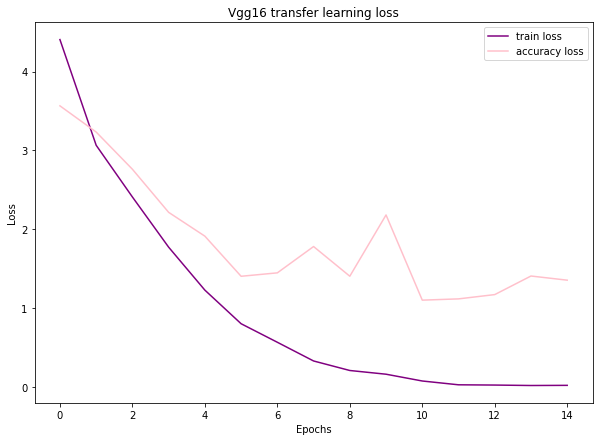

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Vgg16 transfer learning loss")
plt.plot(train_loss, color='purple', label='train loss')
plt.plot(val_loss,color='pink',label='accuracy loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

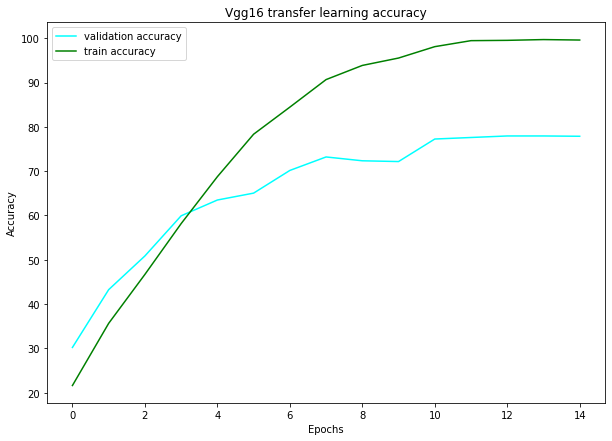

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("Vgg16 transfer learning accuracy")
plt.plot(val_accuracy, color='cyan', label='validation accuracy')
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
result = test(transfer)

print('Accuracy of the network on test images: %0.3f %%' % (100 * result))

Testing



Accuracy of the network on test images: 78.292 %
